In [2]:
from Flower import *
from py21cmfast_tools import calculate_ps, log_bin
import glob
#from py21cmsense import GaussianBeam, Observation, Observatory, PowerSpectrum, hera|
from astropy import units as un
from alive_progress import alive_bar
from time import time
from Leaf import *
import h5py
from powerbox import ignore_zero_absk


In [ ]:
def read_noise_files(path, noise_level) -> list:
    """
    Read noise files based on the noise level specified in the parameters.
    
    Returns:
        list: List of filenames for the noise data.
    """
    if noise_level == "opt":
        files = glob.glob(f"{path}/twentyone_cm_pie/generate_data/calcfiles/opt_mocks/SKA1_Lowtrack_6.0hr_opt_0.*_LargeHII_Pk_Ts1_Tb9_nf0.52_v2.npz")
    elif noise_level == "mod":
        files = glob.glob(f"{path}/twentyone_cm_pie/generate_data/calcfiles/mod_mocks/SKA1_Lowtrack_6.0hr_mod_0.*_LargeHII_Pk_Ts1_Tb9_nf0.52_v2.npz")
    else:
        logging.info("Please choose a valid foreground model")
        sys.exit()
    files.sort(reverse=True)
    return files
         
def add_noise(lightcone, path: str, noise_level: str = "opt") -> np.ndarray:
    """
    Add noise to the simulation.
    
    Args:
        brightness_temp (np.ndarray): The brightness temperature data.
        parameters (np.array): The simulation parameters.
    
    Returns:
        np.ndarray: The brightness temperature data with added noise.
    """
    if path[-1] == "/":
        path = path[:-1]
        
    logging.info('Create mock')
    with open(f"{path}/twentyone_cm_pie/generate_data/redshifts5.npy", "rb") as data:
        box_redshifts = list(np.load(data, allow_pickle=True))
        box_redshifts.sort()

    redshifts = lightcone.lightcone_redshifts
    brightness_temp = lightcone.brightness_temp
    box_len = np.array([])
    y = 0
    z = 0
    for x in range(len(brightness_temp[0][0])):
        if (redshifts[x] > (box_redshifts[y + 1] + box_redshifts[y]) / 2) and x - z > 0:
            box_len = np.append(box_len, x - z)
            y += 1
            z = x
    box_len = np.append(box_len, x - z + 1)
    y = 0
    delta_T_split = []
    for x in box_len:
        delta_T_split.append(brightness_temp[:,:,int(y):int(x+y)])
        y+=x
    mock_lc = np.zeros(brightness_temp.shape)
    cell_size = lightcone.user_params.cell_size.value
    hii_dim = lightcone.user_params.HII_DIM
    k140 = np.fft.fftfreq(hii_dim, d=cell_size / 2. / np.pi)
    index1 = 0
    index2 = 0
    files = read_noise_files(path, noise_level)
    for x in range(len(box_len)):
        with np.load(files[x]) as data:
            ks = data["ks"]
            T_errs = data["T_errs"]
        kbox = np.fft.rfftfreq(int(box_len[x]), d=cell_size / 2. / np.pi)
        volume = hii_dim * hii_dim * box_len[x] * cell_size ** 3
        err21a = np.random.normal(loc=0.0, scale=1.0, size=(hii_dim, hii_dim, int(box_len[x])))
        err21b = np.random.normal(loc=0.0, scale=1.0, size=(hii_dim, hii_dim, int(box_len[x])))
        deldel_T = np.fft.rfftn(delta_T_split[x], s=(hii_dim, hii_dim, int(box_len[x])))
        deldel_T_noise = np.zeros((hii_dim, hii_dim, int(box_len[x])), dtype=np.complex_)
        deldel_T_mock = np.zeros((hii_dim, hii_dim, int(box_len[x])), dtype=np.complex_)
        
        for n_x in range(hii_dim):
            for n_y in range(hii_dim):
                for n_z in range(int(box_len[x] / 2 + 1)):
                    k_mag = np.sqrt(k140[n_x] ** 2 + k140[n_y] ** 2 + kbox[n_z] ** 2)
                    err21 = np.interp(k_mag, ks, T_errs)
                    
                    if k_mag:
                        deldel_T_noise[n_x, n_y, n_z] = np.sqrt(np.pi * np.pi * volume / k_mag ** 3 * err21) * (err21a[n_x, n_y, n_z] + err21b[n_x, n_y, n_z] * 1j)
                    else:
                        deldel_T_noise[n_x, n_y, n_z] = 0
                    
                    if err21 >= 1000:
                        deldel_T_mock[n_x, n_y, n_z] = 0
                    else:
                        deldel_T_mock[n_x, n_y, n_z] = deldel_T[n_x, n_y, n_z] + deldel_T_noise[n_x, n_y, n_z] / cell_size ** 3
        
        delta_T_mock = np.fft.irfftn(deldel_T_mock, s=(hii_dim, hii_dim, box_len[x]))
        index1 = index2
        index2 += delta_T_mock.shape[2]
        mock_lc[:, :, index1:index2] = delta_T_mock
        if x % 5 == 0:
            logging.info(f'mock created to {int(100 * index2 / 2350)}%')
    return mock_lc

mock_lc = add_noise(lc, "../21cm_pie", "opt")

/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/numpy/fft/helper.py:218: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0/(n*d)
/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/numpy/fft/helper.py:221: RuntimeWarning: invalid value encountered in multiply
  return results * val


ValueError: Invalid number of FFT data points (0) specified.

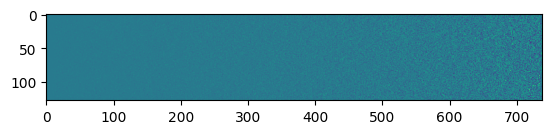

In [32]:

plt.imshow(mock_lc[0, :, :]-lc.brightness_temp[0, :, :])
plt.show()

2.0 Mpc
(355,)
dict_keys(['k', 'ps_1D', 'Nmodes_1D', 'mu', 'var_1D', 'full_kperp', 'full_kpar', 'full_ps_2D', 'full_Nmodes', 'full_var_2D', 'final_ps_2D', 'final_kpar', 'final_kperp', 'final_Nmodes', 'final_var_2D', 'redshifts'])
(1, 15, 15)


/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)


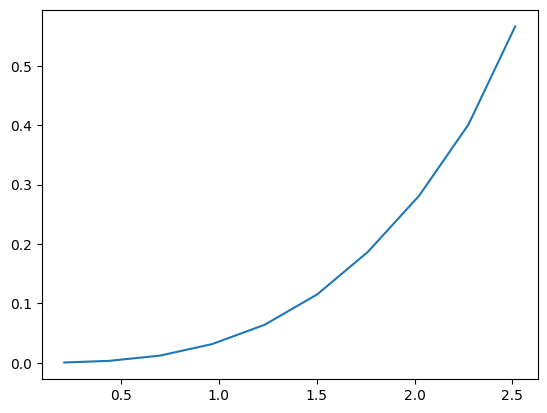

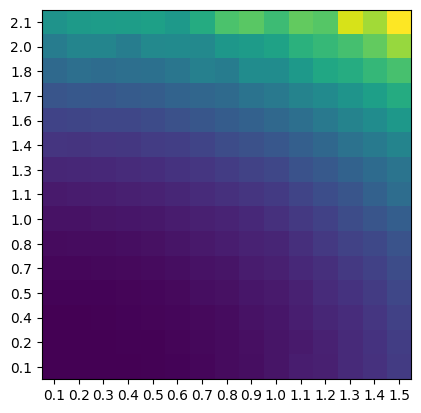

(15, 15)


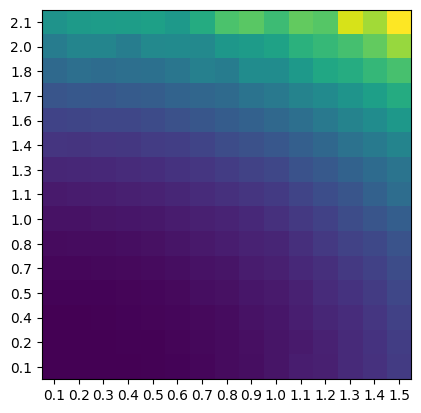

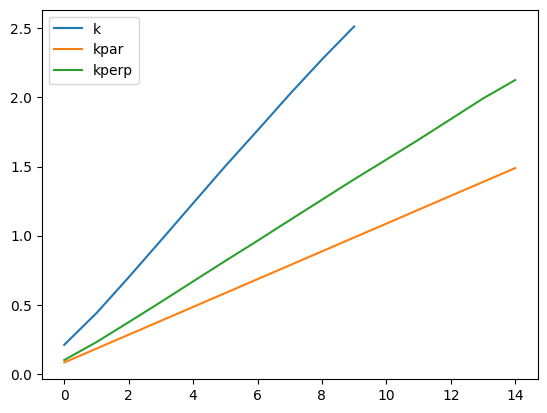

In [7]:
user_params = p21c.inputs.UserParams(**{
    "HII_DIM": 100,
    "BOX_LEN": 200,
})
print(user_params.cell_size)
lcn = p21c.RectilinearLightconer.with_equal_cdist_slices(
min_redshift=6,
max_redshift=8,
quantities=("brightness_temp",),
resolution=user_params.cell_size,
# index_offset=0,
)

print(lcn.lc_redshifts.shape)

res = calculate_ps(lc = np.random.rand(100,100,lcn.lc_redshifts.shape[-1]), 
                    lc_redshifts=lcn.lc_redshifts, 
                    box_length=200, 
                    box_side_shape=100,
                    log_bins=False, zs = (8,), 
                    calc_1d=True, calc_2d=True, get_variance=True,
                    nbins_1d=10, bin_ave=True, kpar_bins=15, nbins=15,
                    k_weights=ignore_zero_absk,postprocess=True)
print(res.keys())
print(res["final_ps_2D"].shape)
plt.plot(res["k"], res["ps_1D"][0])
plt.show()
plt.imshow(res["final_ps_2D"][0][::-1])
plt.xticks(np.linspace(0,res["final_kpar"].shape[0]-1,res["final_kpar"].shape[0]), np.round(res["final_kpar"],1))
plt.yticks(np.linspace(0,res["final_kperp"].shape[0]-1,res["final_kperp"].shape[0]), np.round(res["final_kperp"],1)[::-1])
plt.show()
print(res["final_var_2D"][0].shape)
plt.imshow(res["final_ps_2D"][0][::-1])
plt.xticks(np.linspace(0,res["final_kpar"].shape[0]-1,res["final_kpar"].shape[0]), np.round(res["final_kpar"],1))
plt.yticks(np.linspace(0,res["final_kperp"].shape[0]-1,res["final_kperp"].shape[0]), np.round(res["final_kperp"],1)[::-1])
plt.show(
)
plt.plot(res["k"], label="k")
plt.plot(res["final_kpar"], label="kpar")
plt.plot(res["final_kperp"], label="kperp")
plt.legend()
plt.show()

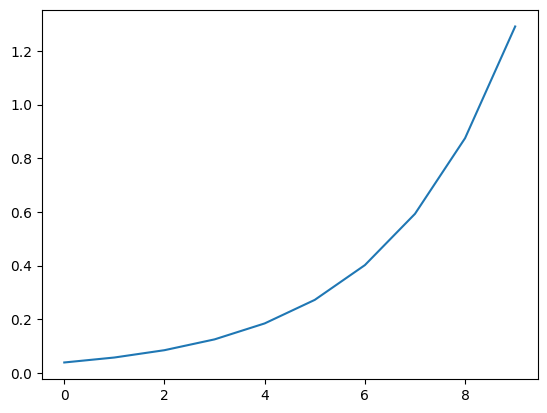

In [ ]:
# add noise to lc / create mock



In [3]:
tstart = time()
user_parameter = {
    "HII_DIM": 128,
    "BOX_LEN": 250,
    "N_THREADS": 6,
    "USE_INTERPOLATION_TABLES": True,
    "PERTURB_ON_HIGH_RES": False,
    "USE_FFTW_WISDOM": True,
    "MINIMIZE_MEMORY": False
}
flag_options = {
    "INHOMO_RECO": True,
    "USE_TS_FLUCT": False,
    "USE_MASS_DEPENDENT_ZETA": False,
}

astro_parameter = {
    "INHOMO_RECO": True,
}

user_params = p21c.UserParams(**user_parameter)
flag_params = p21c.FlagOptions(**flag_options)
astro_params = p21c.AstroParams(**astro_parameter)
cosmo_params = p21c.CosmoParams()


redshift = [6.8,13]

# Initialize the wrapper with the above given parameters,
# for more details check the docs or the tutorial.ipynb.
sim = Leaf(user_params=user_parameter, flag_options=flag_options, astro_params=astro_parameter, debug=True, redshift=redshift)



lc = sim.run_lightcone(redshift = redshift,
                save = False,
                random_seed = 42069,
                sanity_check= False,
                filter_peculiar= False,
                user_params = user_parameter,
                flag_options = flag_options,
                fields = ["brightness_temp", "xH_box"],)
tend = time()
print(tend-tstart)


Set initial parameters...
Begin lightcone simulation ...
Parameter successfully refreshed.
Current parameters are:
astro_params: AstroParams:
    ALPHA_ESC       : -0.5
    ALPHA_STAR      : 0.5
    ALPHA_STAR_MINI : 0.5
    A_LW            : 2.0
    A_VCB           : 1.0
    BETA_LW         : 0.6
    BETA_VCB        : 1.8
    F_ESC10         : 0.1
    F_ESC7_MINI     : 0.01
    F_H2_SHIELD     : 0.0
    F_STAR10        : 0.05011872336272722
    F_STAR7_MINI    : 0.01
    HII_EFF_FACTOR  : 30.0
    ION_Tvir_MIN    : 49999.9995007974
    L_X             : 1e+40
    L_X_MINI        : 1e+40
    M_TURN          : 501187233.6272715
    NU_X_THRESH     : 500.0
    N_RSD_STEPS     : 20
    R_BUBBLE_MAX    : 50.0
    X_RAY_SPEC_INDEX: 1.0
    X_RAY_Tvir_MIN  : 49999.9995007974
    t_STAR          : 0.5
    
cosmo_params: CosmoParams:
    OMb        : 0.04897468161869667
    OMm        : 0.30964144154550644
    POWER_INDEX: 0.9665
    SIGMA_8    : 0.8102
    hlittle    : 0.6766
    
user_params

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import py21cmfast as p21c

# Generate example data
image_data = lc.brightness_temp[0,:,:].T  # Data for imshow
x = np.linspace(0, len(image_data[0])-1, len(image_data[0]))
y1 = np.mean(lc.brightness_temp, (0,1))  # global brightness temperature
y2 = np.mean(lc.xH_box, (0,1))  # global ionization history

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 1, 1], wspace=0.05)

# Add axes
ax_imshow = fig.add_subplot(gs[0, 0])  # Imshow plot
ax_plot1 = fig.add_subplot(gs[0, 1], sharey=ax_imshow)  # First regular plot
ax_plot2 = fig.add_subplot(gs[0, 2], sharey=ax_imshow)  # Second regular plot

# Plot data
im = ax_imshow.imshow(image_data, aspect='auto', origin='lower', cmap='viridis')
ax_plot1.plot(y1, x, label="sin", color="blue")
ax_plot2.plot(y2, x, label="cos", color="red")

# Add labels and legends
ax_imshow.set_ylabel(r"$z$")
ax_imshow.set_xlabel("Extent [Mpc]")
ax_plot1.set_xlabel(r"$T_b$ [mK]")
ax_plot2.set_xlabel(r"$x_H$")
ax_plot1.legend(loc="upper right")
ax_plot2.legend(loc="upper right")

# Optional: Add colorbar for imshow
#cbar = fig.colorbar(im, ax=ax_imshow, fraction=0.046, pad=0.04)
#cbar.set_label("Color Intensity")

# Show the plot
plt.show()


NameError: name 'p21c' is not defined

2.9 min

In [2]:
low = (lambda x: [.7*x])
high = (lambda x: [1.3*x])
default = [0.05012, 0.1, 5.012e8, .5]
main = [True, True, 40, 500, 5, 30]

parameters = np.asarray([
    main + default,
    main + low(default[0]) + default[1:],
    main + high(default[0]) + default[1:],
    
    main + [default[0]] + low(default[1]) + default[2:],
    main + [default[0]] + high(default[1]) + default[2:],
    
    main + default[:2] + low(default[2]) + [default[3]],
    main + default[:2] + high(default[2]) + [default[3]],
    
    main + default[:3] + low(default[3]),
    main + default[:3] + high(default[3])
])
print(parameters[:,-4:])

[[5.0120e-02 1.0000e-01 5.0120e+08 5.0000e-01]
 [3.5084e-02 1.0000e-01 5.0120e+08 5.0000e-01]
 [6.5156e-02 1.0000e-01 5.0120e+08 5.0000e-01]
 [5.0120e-02 7.0000e-02 5.0120e+08 5.0000e-01]
 [5.0120e-02 1.3000e-01 5.0120e+08 5.0000e-01]
 [5.0120e-02 1.0000e-01 3.5084e+08 5.0000e-01]
 [5.0120e-02 1.0000e-01 6.5156e+08 5.0000e-01]
 [5.0120e-02 1.0000e-01 5.0120e+08 3.5000e-01]
 [5.0120e-02 1.0000e-01 5.0120e+08 6.5000e-01]]


In [3]:
low = (lambda x: [.7*x])
high = (lambda x: [1.3*x])
default = [np.log10(0.05012), np.log10(0.1), np.log10(5.012e8), .5]
main = [True, False, 40, 500, 5, 30]

parameters = [
    main + default,
    main + low(default[0]) + default[1:],
    main + high(default[0]) + default[1:],
    
    main + [default[0]] + low(default[1]) + default[2:],
    main + [default[0]] + high(default[1]) + default[2:],
    
    main + default[:2] + low(default[2]) + [default[3]],
    main + default[:2] + high(default[2]) + [default[3]],
    
    main + default[:3] + low(default[3]),
    main + default[:3] + high(default[3])
]

print(parameters)

with alive_bar(len(parameters), force_tty=True) as bar:
    for i, params in enumerate(parameters):
        tstart = time()
        # 0 inh,ts = off,off :    ~ 5.5 min
        # 1 inh,ts = on,off :     ~ 4.1 min
        # 2 inh,ts = off,on :     ~ 6 min
        # 3 inh,ts = on,on :      ~ 6.2 min

        # To set the parameter ranges, the parameter must be given as a dict, following the dict
        # structure defined in parameter.yaml. The values must be an array which is handed over
        # to the samplef defined above. In this case it is [start, stop].
        user_parameter = {
            "HII_DIM": 350,
            "BOX_LEN": 700,
            "N_THREADS": 12,
            #"USE_INTERPOLATION_TABLES": True,
            "PERTURB_ON_HIGH_RES": False,
            "USE_FFTW_WISDOM": True,
            "MINIMIZE_MEMORY": True
        }
        flag_options = {
            "INHOMO_RECO": params[0],
            "USE_TS_FLUCT": params[1],
            "USE_MASS_DEPENDENT_ZETA": True,
        }

        astro_params = {
            "INHOMO_RECO": params[0],
            "L_X": params[2],
            "NU_X_THRESH": params[3],
            "ION_Tvir_MIN": params[4],
            "HII_EFF_FACTOR": params[5],
            "F_STAR10": params[6],
            "F_ESC10": params[7],
            "M_TURN": params[8],
            "t_STAR": params[9]
        }

        redshift = [6,15]

        # Initialize the wrapper with the above given parameters,
        # for more details check the docs or the tutorial.ipynb.
        sim = Leaf(user_params=user_parameter, flag_options=flag_options, astro_params=astro_params, debug=True, redshift=redshift)

        lc = sim.run_lightcone(redshift = redshift,
                        save = True,
                        random_seed = 42069,
                        sanity_check= False,
                        filter_peculiar= False,
                        user_params = user_parameter,
                        flag_options = flag_options,
                        run_id = i)
        tend = time()
        print(tend-tstart)
        bar()
        break

[[True, False, 40, 500, 5, 30, -1.2999889376778877, -1.0, 8.700011062322112, 0.5], [True, False, 40, 500, 5, 30, -0.9099922563745213, -1.0, 8.700011062322112, 0.5], [True, False, 40, 500, 5, 30, -1.689985618981254, -1.0, 8.700011062322112, 0.5], [True, False, 40, 500, 5, 30, -1.2999889376778877, -0.7, 8.700011062322112, 0.5], [True, False, 40, 500, 5, 30, -1.2999889376778877, -1.3, 8.700011062322112, 0.5], [True, False, 40, 500, 5, 30, -1.2999889376778877, -1.0, 6.090007743625478, 0.5], [True, False, 40, 500, 5, 30, -1.2999889376778877, -1.0, 11.310014381018746, 0.5], [True, False, 40, 500, 5, 30, -1.2999889376778877, -1.0, 8.700011062322112, 0.35], [True, False, 40, 500, 5, 30, -1.2999889376778877, -1.0, 8.700011062322112, 0.65]]
on 0: Set initial parameters...                                                 
on 0: Begin lightcone simulation ...                                            
on 0: Parameter successfully refreshed.                                         
on 0: Current pa

on 0: /home/allomere/Documents/projects/master/test-venv/lib/python3.12/site-packages/py21cmfast/inputs.py:598: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
        warnings.warn(
/home/allomere/Documents/projects/master/test-venv/lib/python3.12/site-packages/py21cmfast/wrapper.py:3208: DeprecationWarning: passing redshift directly is deprecated, please use the Lightconer interface instead
        warnings.warn(


|⚠︎                                       | (!) 0/9 [0%] in 0.1s (0.00/s)        


ValueError: If trying to minimize memory usage, you must be caching. Set write=True!

In [3]:
summary_statistics_parameters = {
                    "BOX_LEN": 200,
                    "HII_DIM": 28,
                    "z-eval": np.linspace(7, 24, 10),
                    "bins": 8,
                    }
img = np.random.rand(28,28,470)
lab = [8.4215e+00, 2.6596e-01, 3.8021e+01, 8.8295e+02, 4.7991e+00, 8.1937e+01]
WDM,OMm,LX,E0,Tvir,Zeta = lab
with p21c.global_params.use(**{"M_WDM":WDM}):
    cosmo_params = p21c.inputs.CosmoParams({"OMm": OMm})
    astro_params = p21c.inputs.AstroParams({
        "L_X": LX,
        "NU_X_THRESH": E0,
        "ION_Tvir_MIN": Tvir,
        "HII_EFF_FACTOR": Zeta,
    })

    user_params = p21c.UserParams(
        HII_DIM=summary_statistics_parameters['HII_DIM'], 
        BOX_LEN=summary_statistics_parameters['BOX_LEN'], KEEP_3D_VELOCITIES=False
    )

    lcn_distances = p21c.RectilinearLightconer.with_equal_cdist_slices(
        min_redshift=5.5,
        max_redshift=35.05,
        cosmo=cosmo_params.cosmo,
        quantities=('brightness_temp'),
        resolution=user_params.cell_size,
        # index_offset=0,
    ).lc_distances

    flag_options, random_seed = p21c.inputs.FlagOptions(), 42

    lc = p21c.LightCone(redshift=5.5, 
    cosmo_params=cosmo_params,
    flag_options=flag_options,
    user_params=user_params,
    random_seed=random_seed,
    distances=lcn_distances,
    astro_params=astro_params,
    lightcones={"brightness_temp":img},
    current_redshift=35.05)
    print(lc.lightcone_redshifts)

[ 5.50000001  5.51391792  5.5278802   5.54188701  5.55593856  5.570035
  5.58417652  5.59836337  5.61259574  5.62687374  5.64119769  5.65556774
  5.66998402  5.68444685  5.69895637  5.71351276  5.72811625  5.74276706
  5.75746538  5.77221137  5.78700542  5.80184751  5.81673795  5.831677
  5.84666476  5.86170159  5.8767876   5.89192302  5.90710805  5.92234297
  5.93762803  5.95296328  5.96834917  5.98378571  5.99927331  6.01481206
  6.03040231  6.0460441   6.06173786  6.07748378  6.09328198  6.10913276
  6.12503646  6.14099314  6.15700314  6.17306666  6.18918401  6.20535534
  6.22158097  6.23786107  6.25419593  6.27058584  6.28703099  6.30353166
  6.32008798  6.33670044  6.35336912  6.37009433  6.38687633  6.40371536
  6.42061164  6.43756555  6.45457727  6.47164707  6.4887752   6.50596202
  6.52320768  6.54051256  6.55787684  6.57530082  6.59278482  6.61032913
  6.62793396  6.64559957  6.66332635  6.68111448  6.69896431  6.71687611
  6.73485019  6.75288676  6.77098625  6.7891488   6.807

blub :3
blub :3
blub :3
blub :3
blub :3
blub :3
blub :3
blub :3
blub :3


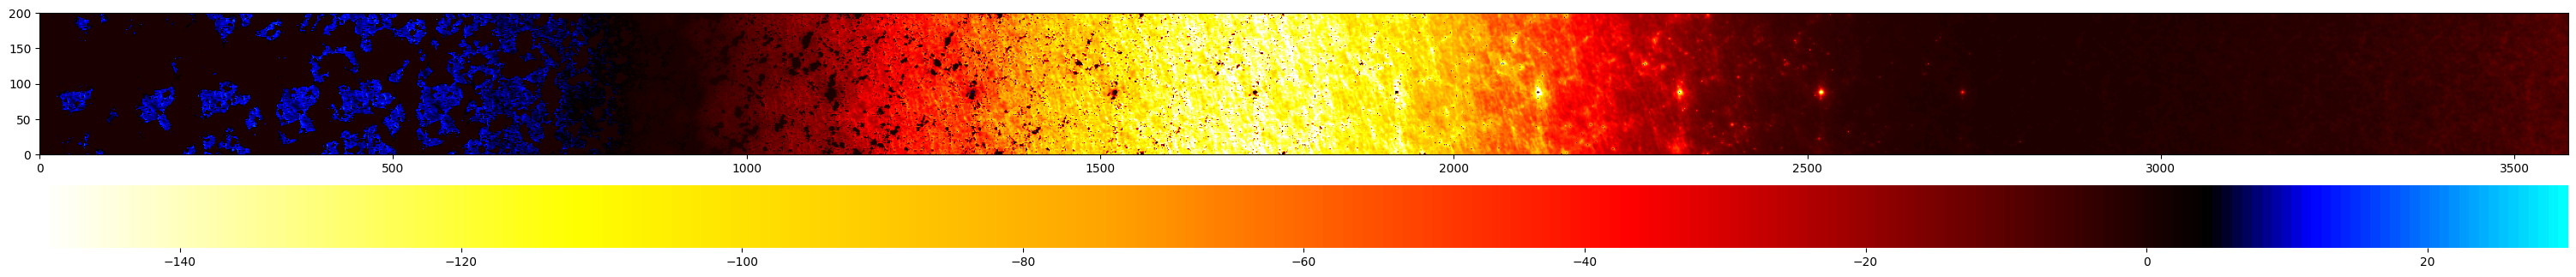

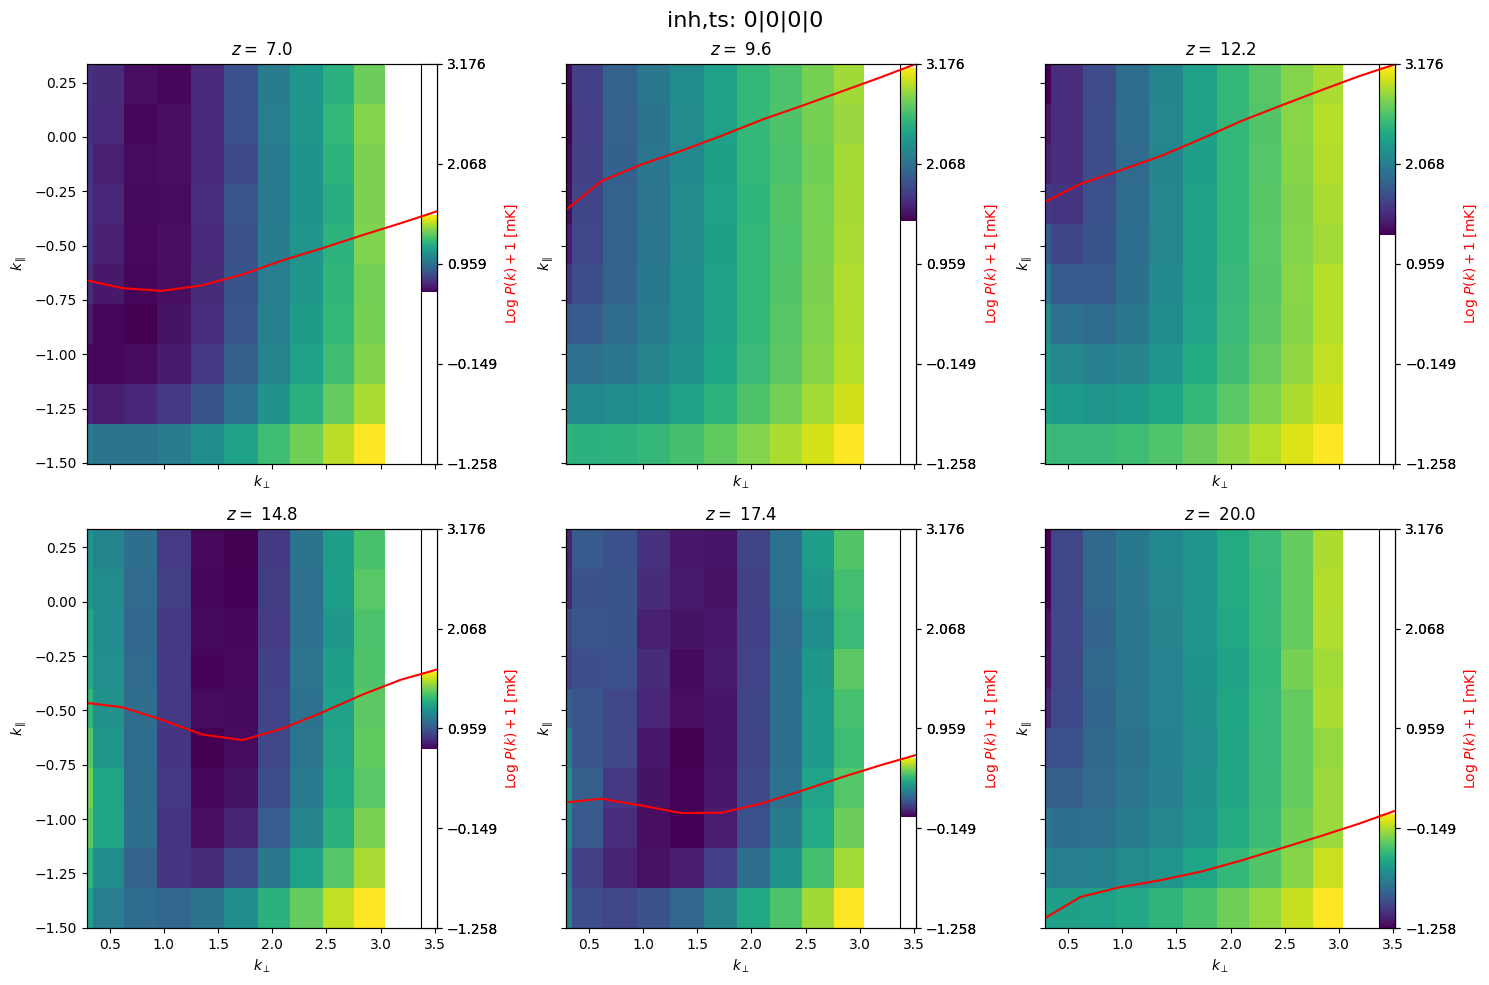

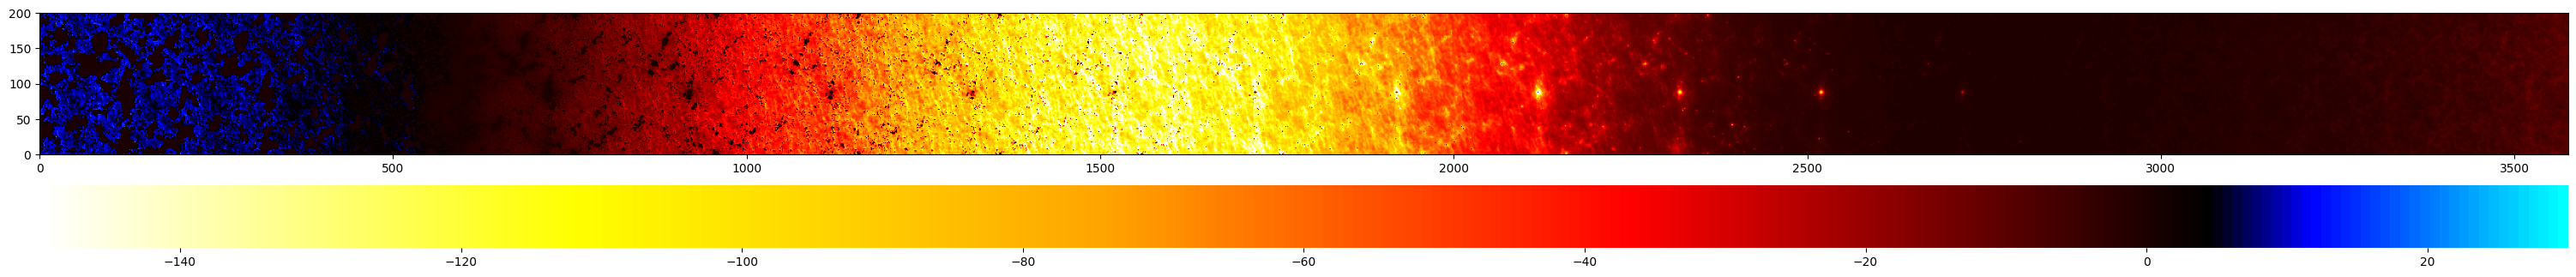

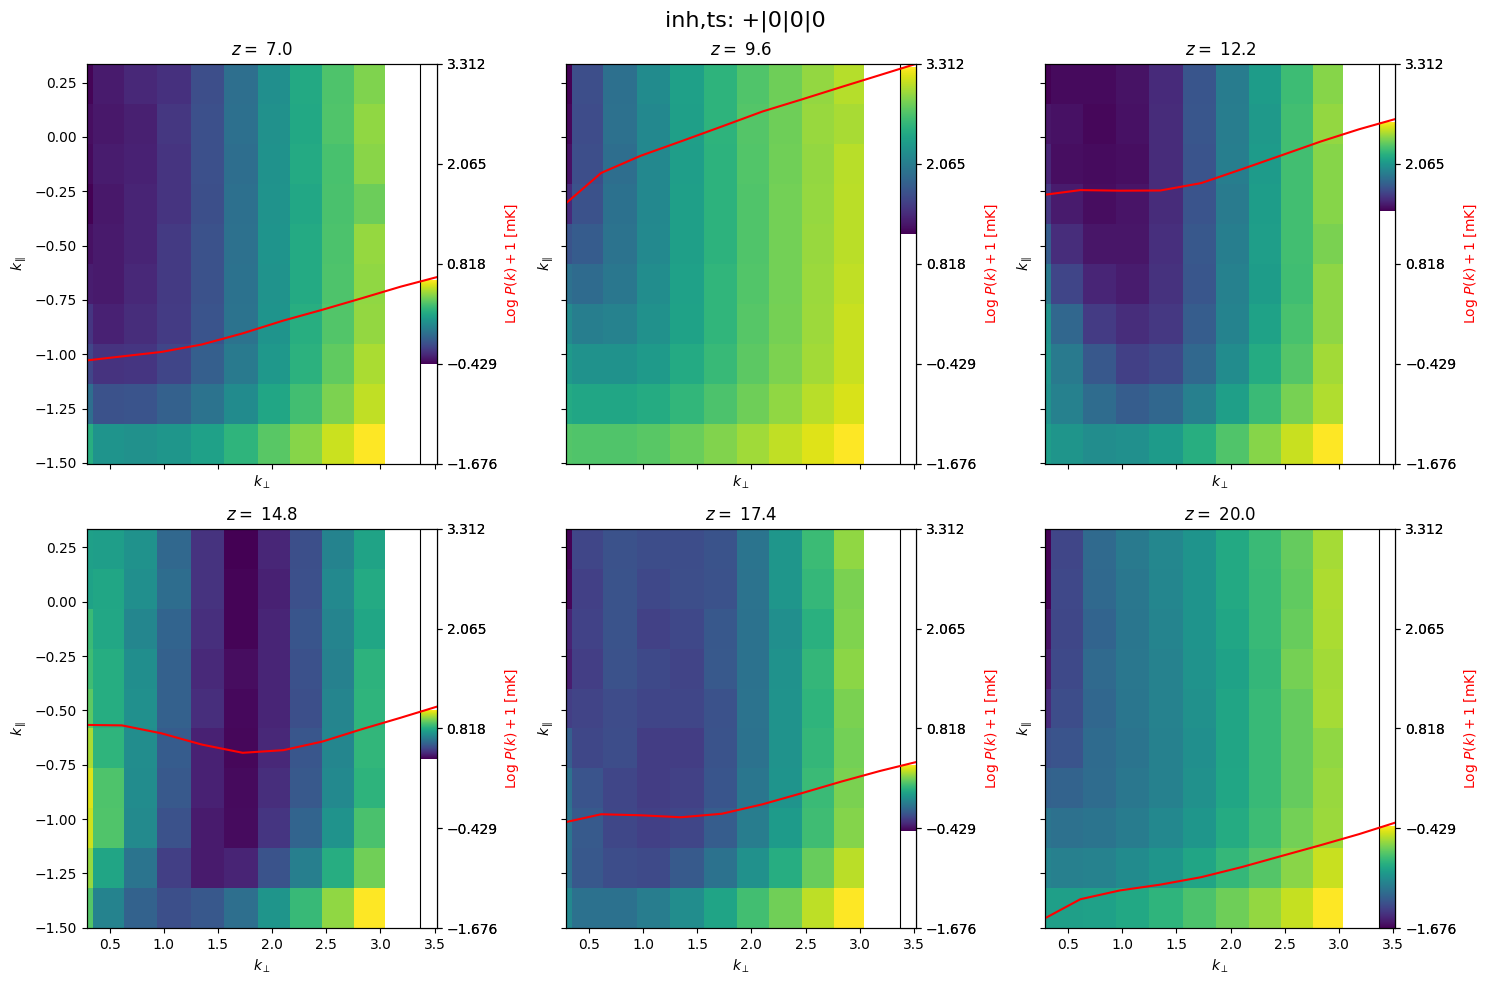

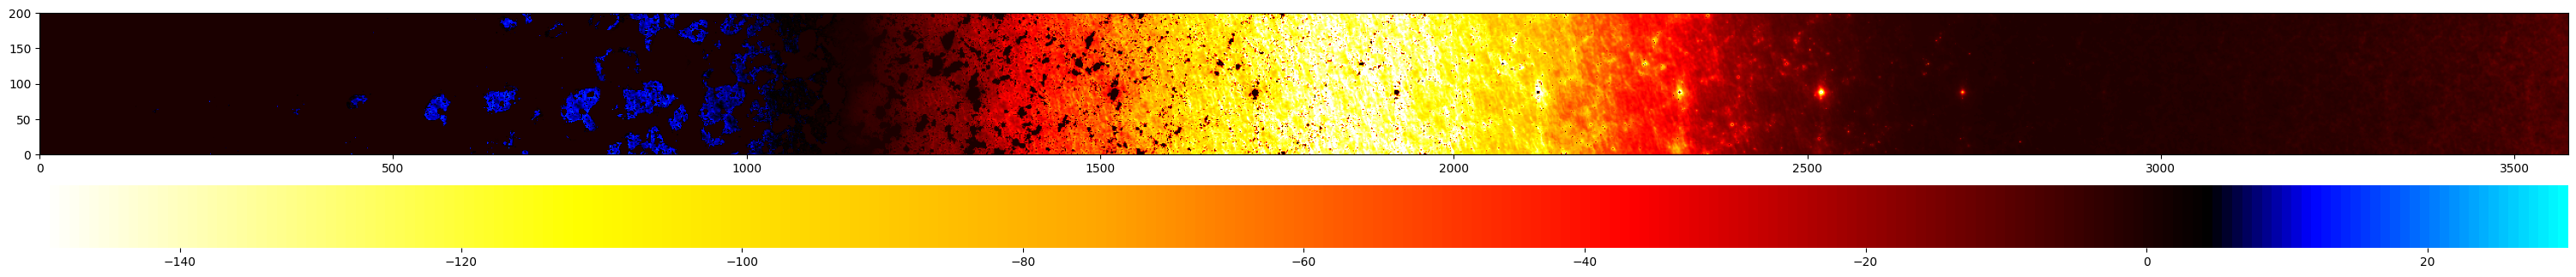

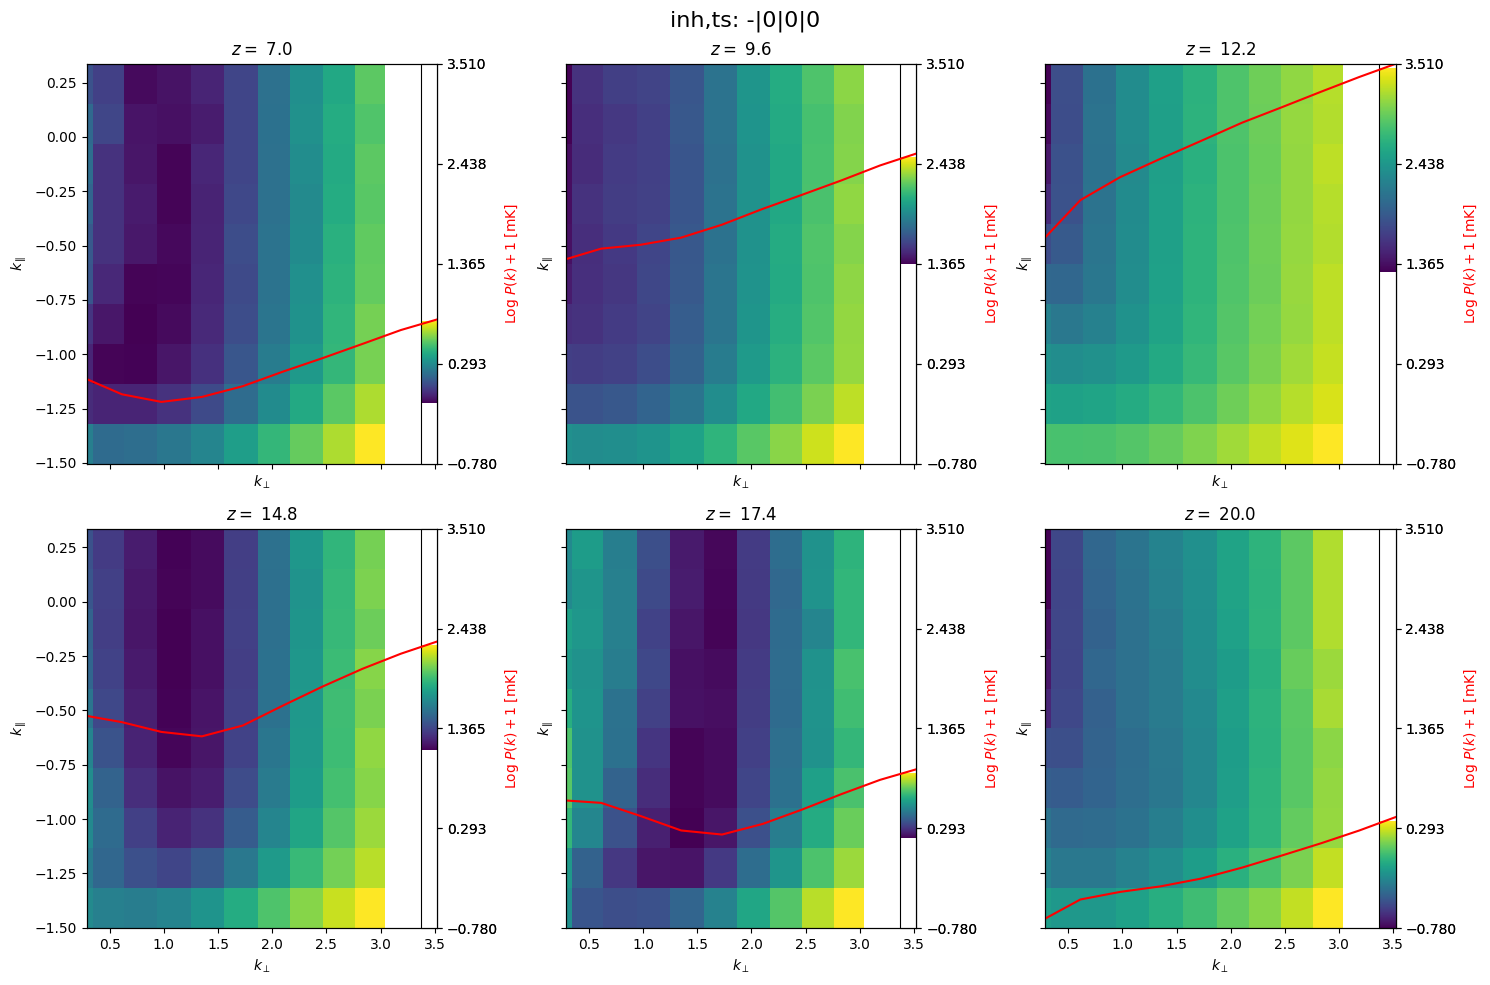

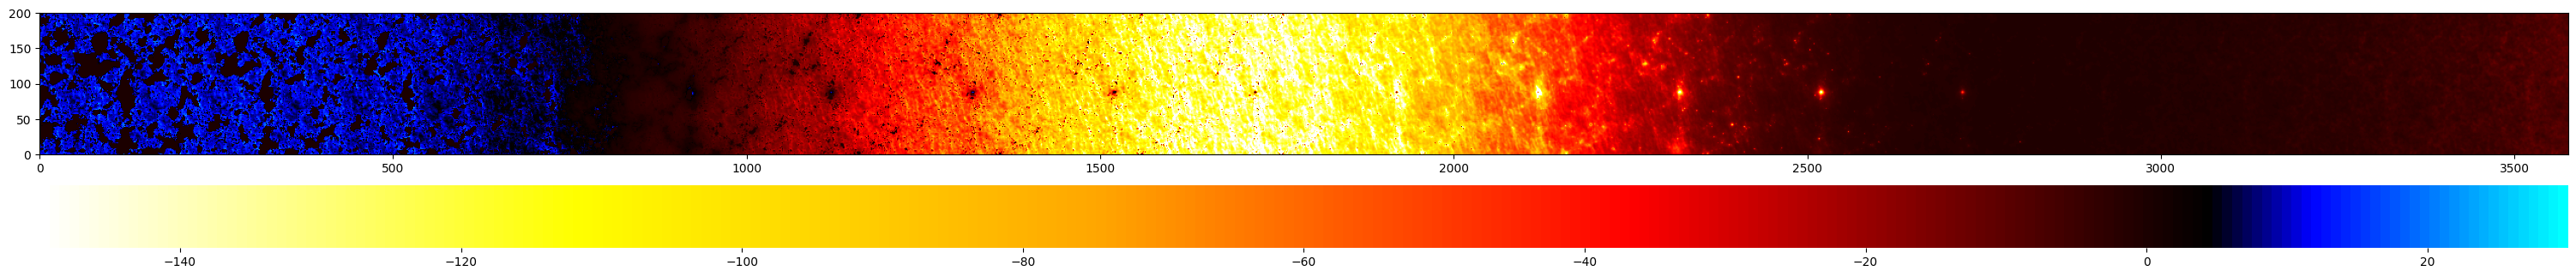

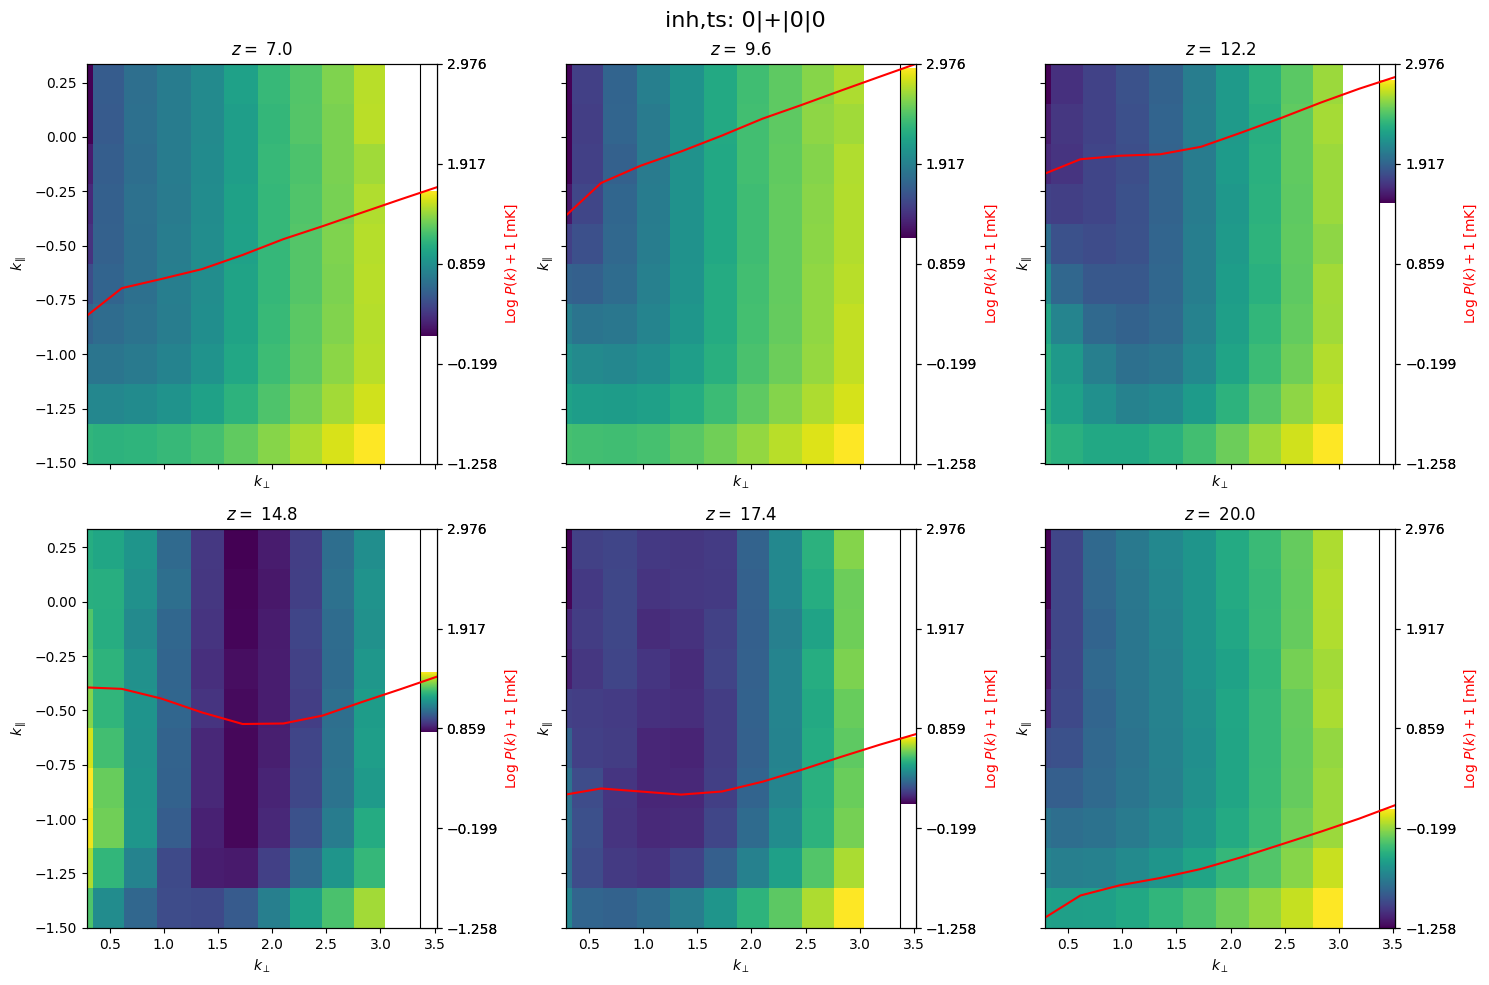

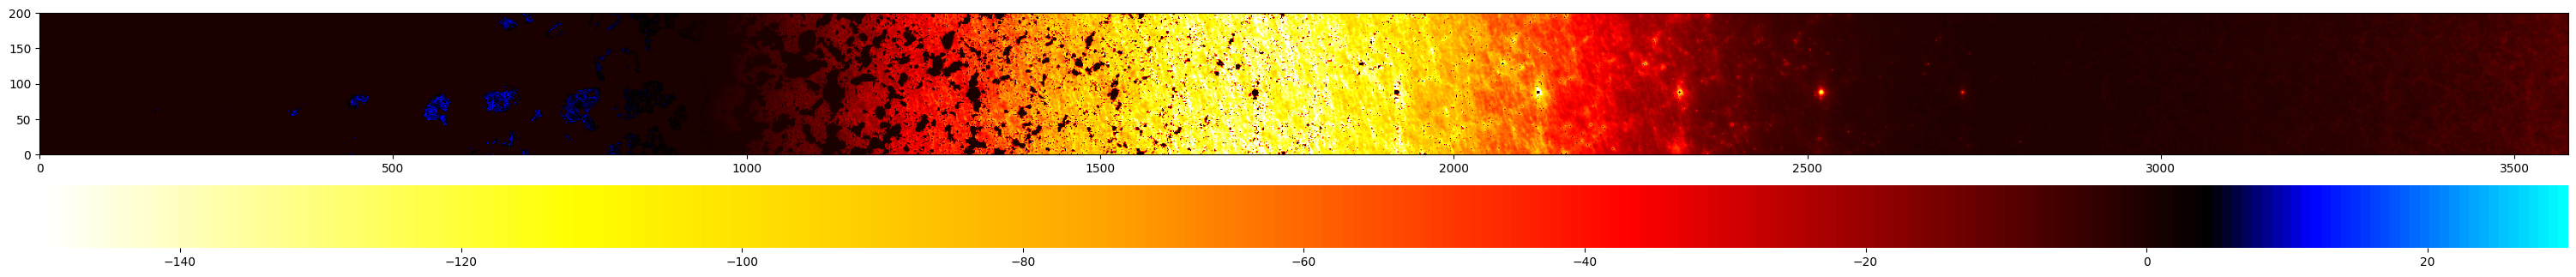

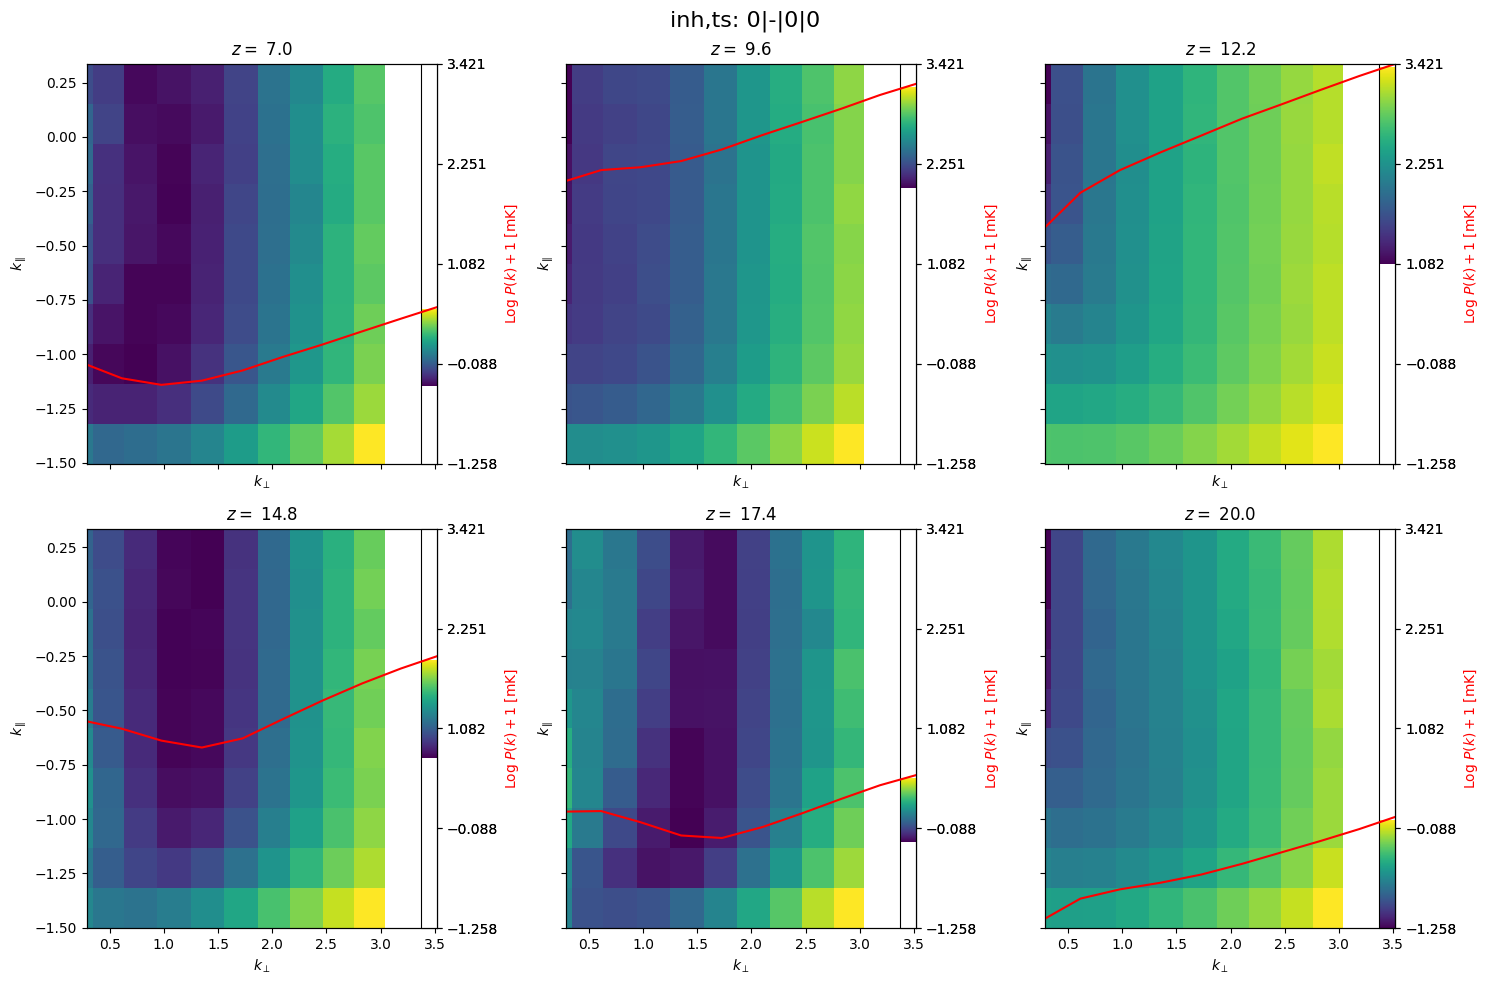

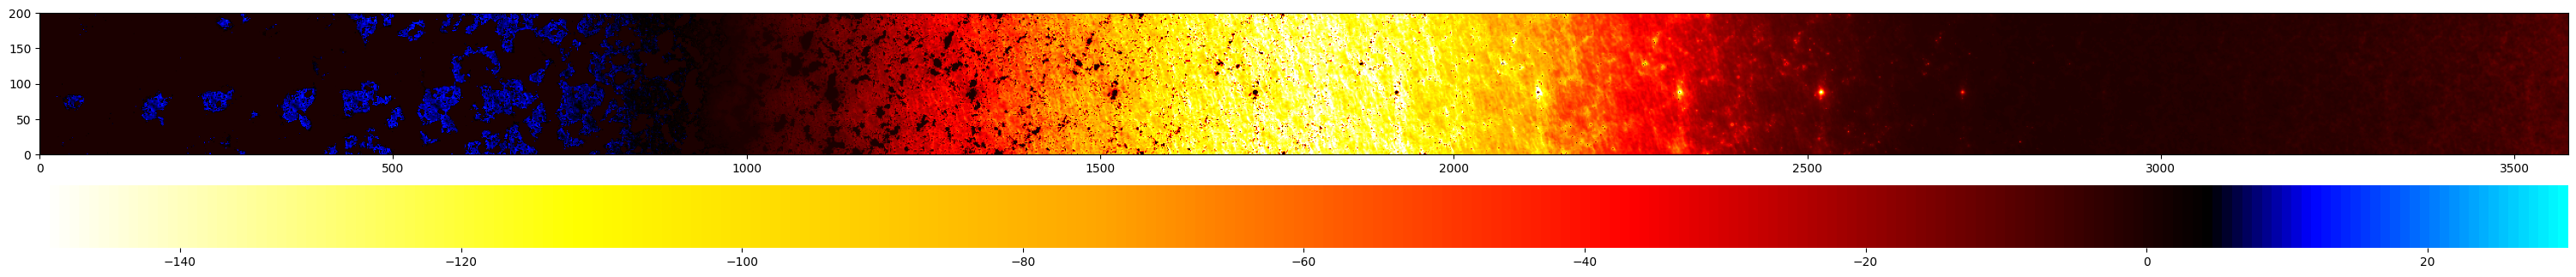

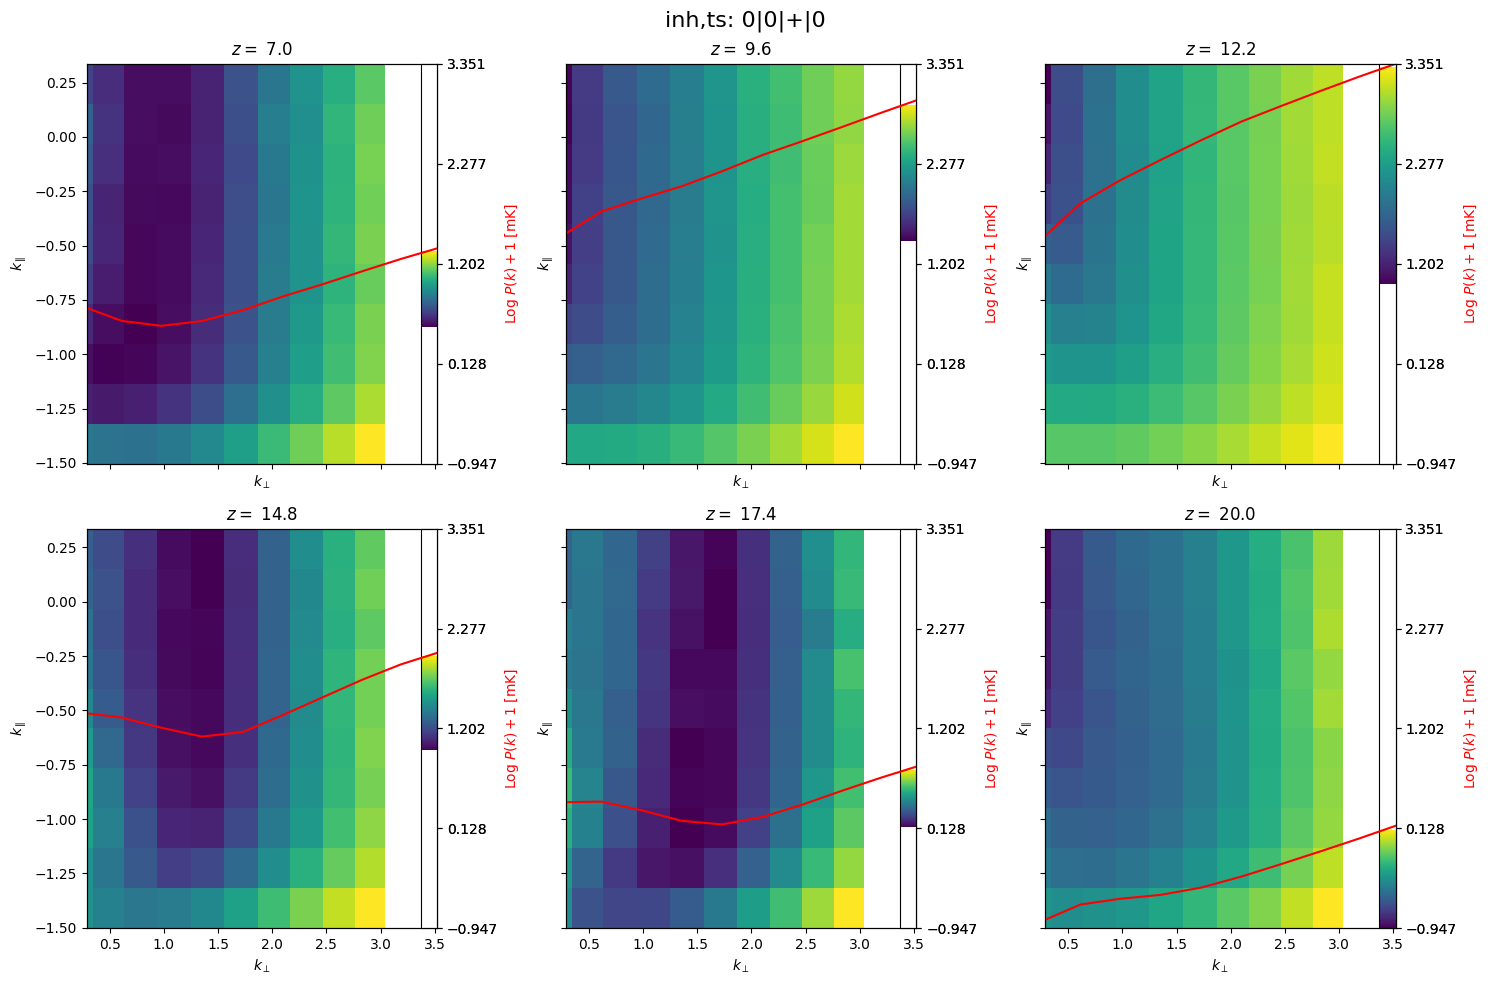

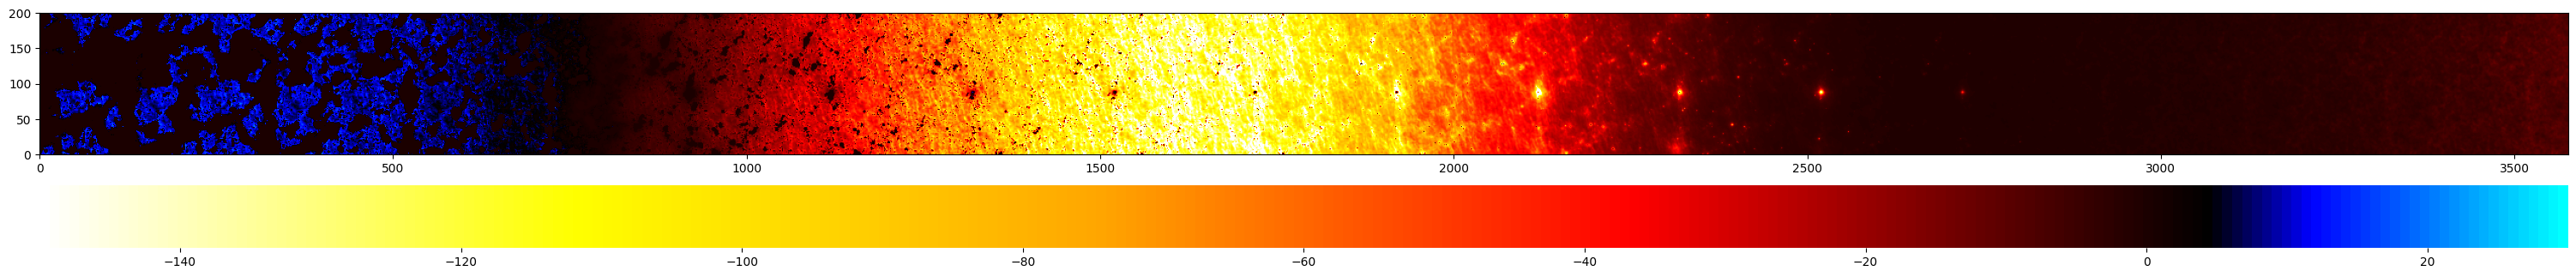

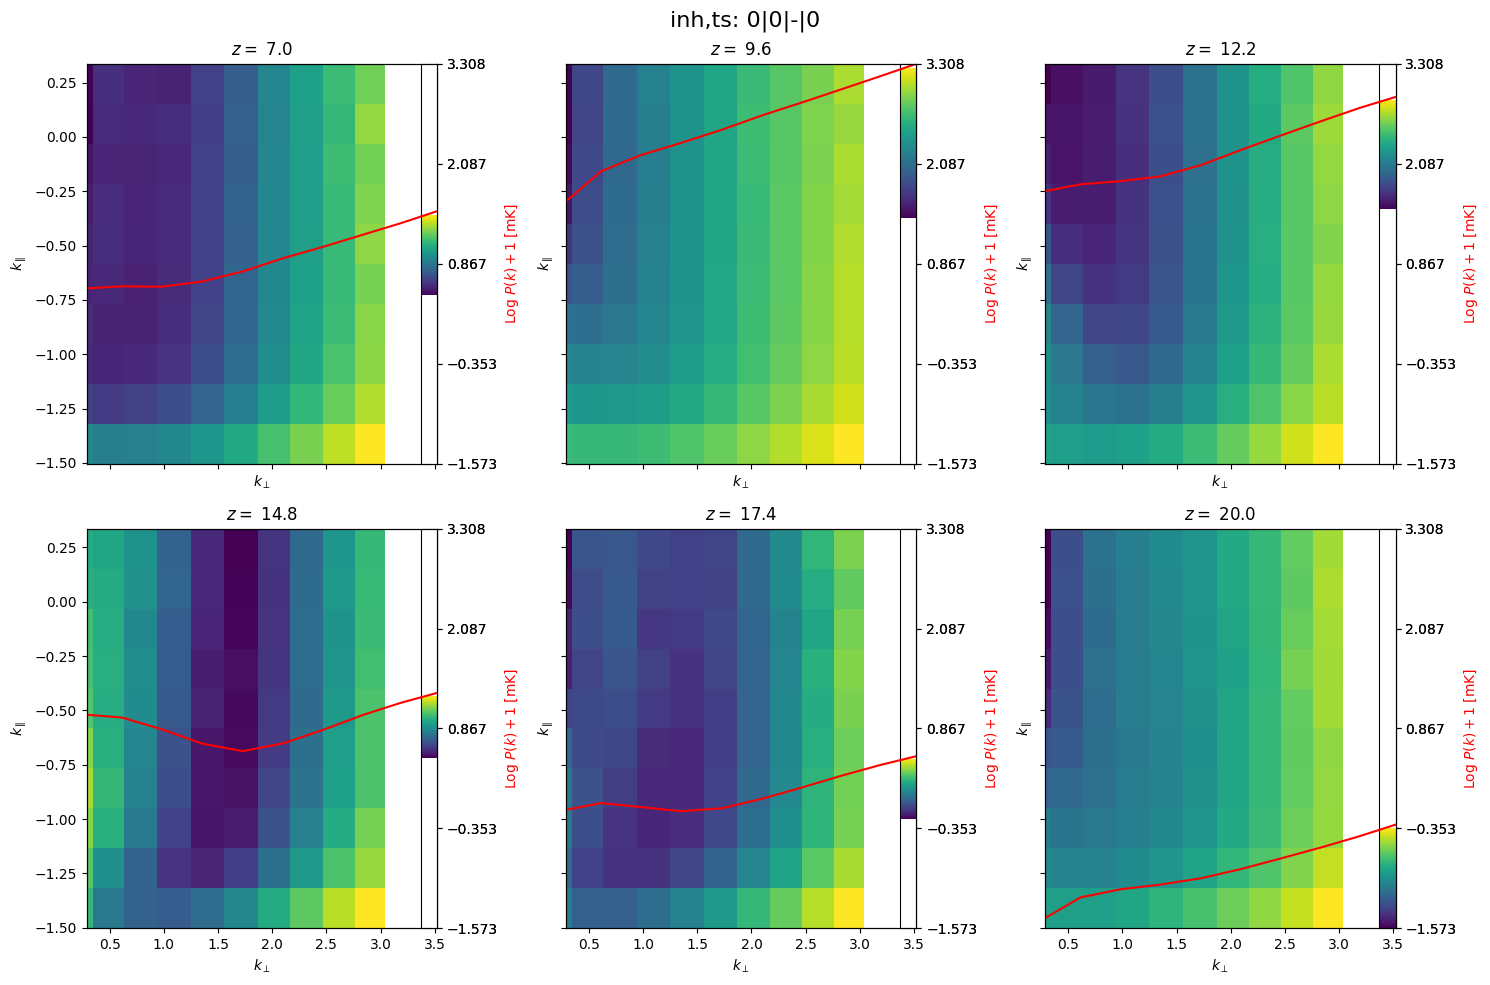

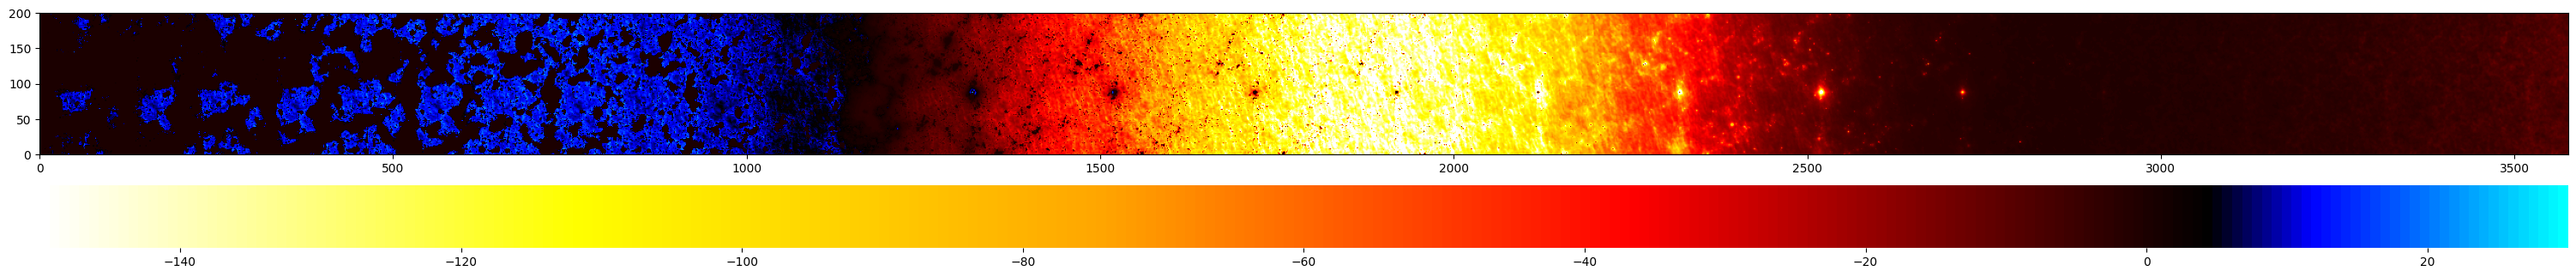

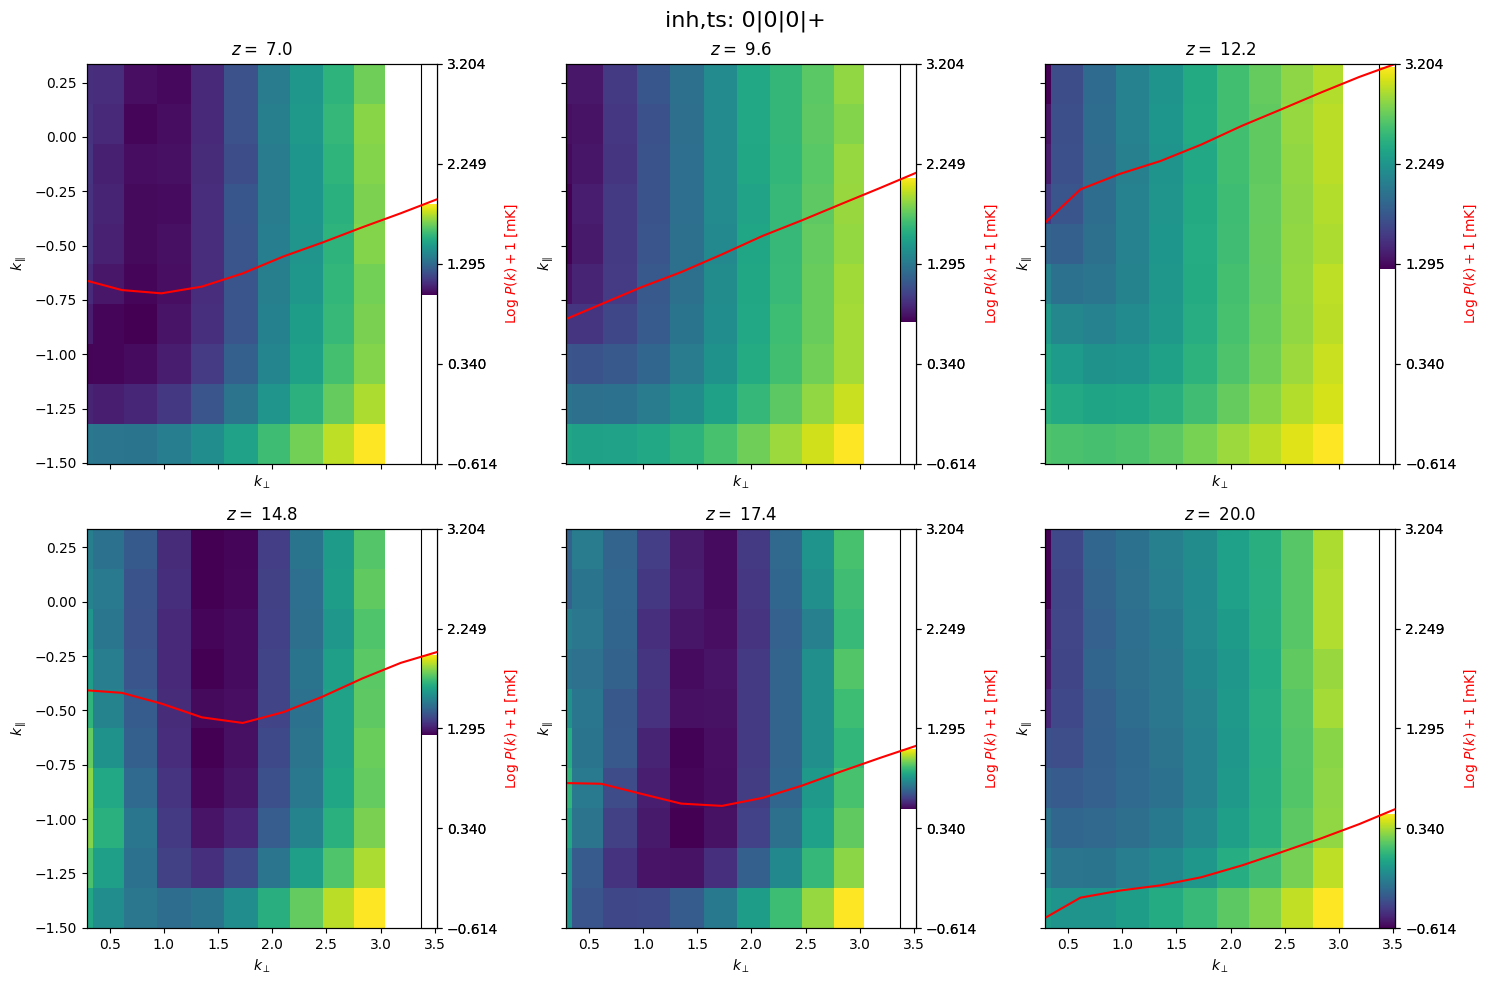

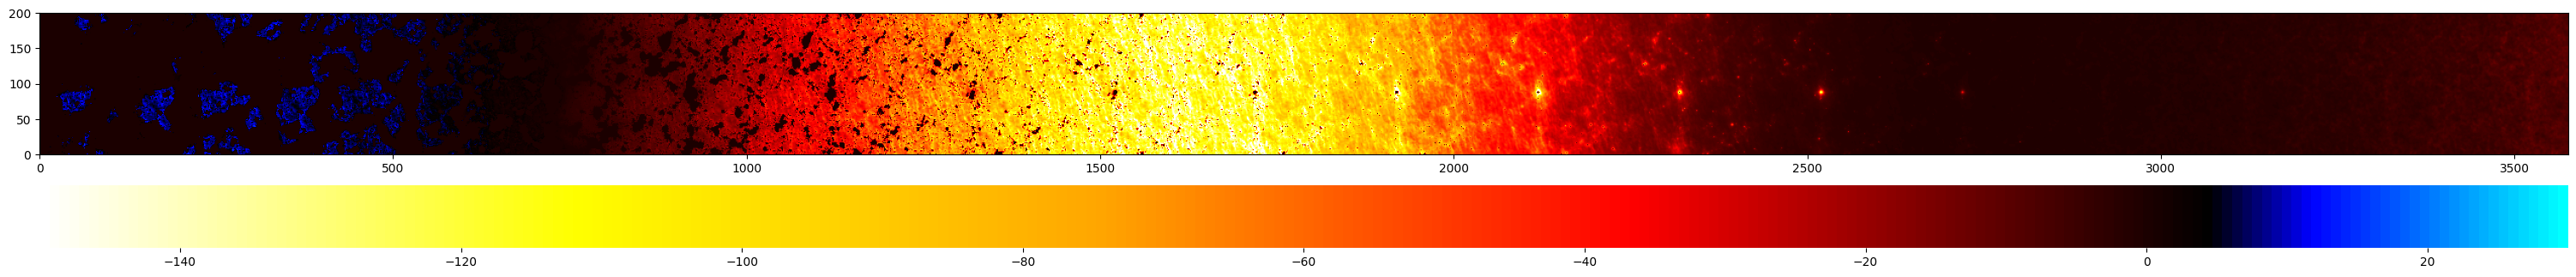

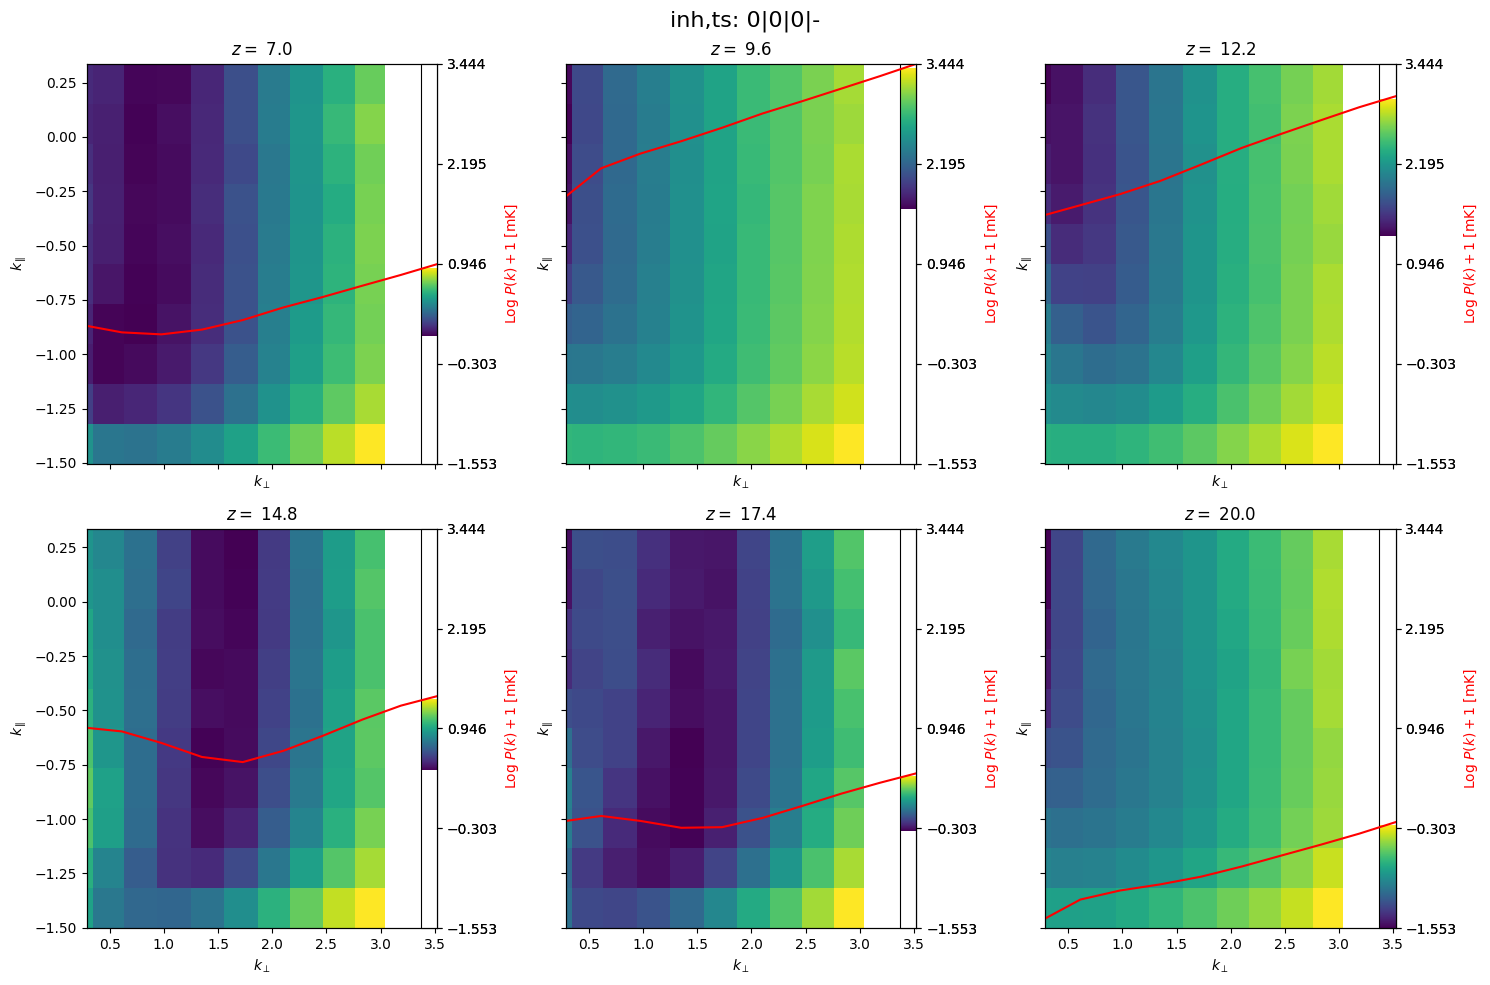

In [26]:
from py21cmfast_tools import calculate_ps
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  # To control colorbar placement

run_name = [
    "0|0|0|0",
    "+|0|0|0",
    "-|0|0|0",
    "0|+|0|0",
    "0|-|0|0",
    "0|0|+|0",
    "0|0|-|0",
    "0|0|0|+",
    "0|0|0|-"
]
zslices = 6
bins = 10
for i, name in enumerate(run_name):
    with h5py.File(f'/home/allomere/Documents/projects/master/data/lightcone_np/simrun_{i}.h5', 'r+') as h5file:
        dataset = h5file['global_quantities']

    lc = p21c.outputs.LightCone.read(f'/home/allomere/Documents/projects/master/data/lightcone_np/simrun_{i}.h5')
    try:
        fig, _ = p21c.plotting.lightcone_sliceplot(lc)
        fig.tight_layout()
        fig.savefig(f'./lc_{name}.png', dpi=350)
        fig.clf()
    except:
        print("blub :3")

    fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    ax = ax.flatten()
    fig.suptitle(f'inh,ts: {name}', fontsize=16)

    '''if i == 0:
        res = calculate_ps(lc=lc.lightcones['brightness_temp'], lc_redshifts=lc.lightcone_redshifts, 
                       box_length=lc.user_params.BOX_LEN, box_side_shape=lc.user_params.HII_DIM,
                       log_bins=False, zs=np.linspace(7, 20, zslices), calc_1d=False, calc_2d=True, 
                       kpar_bins=bins, nbins=bins, nbins_1d=bins, bin_ave=False, 
                       k_weights=ignore_zero_absk, postprocess=True)
        #bins = res["final_kperp"]'''

    res = calculate_ps(lc=lc.lightcones['brightness_temp'], lc_redshifts=lc.lightcone_redshifts, 
                       box_length=lc.user_params.BOX_LEN, box_side_shape=lc.user_params.HII_DIM,
                       log_bins=False, zs=np.linspace(7, 20, zslices), calc_1d=True, calc_2d=True, 
                       kpar_bins=bins, nbins=bins, nbins_1d=bins, bin_ave=True, 
                       k_weights=ignore_zero_absk, postprocess=True)

    ps_1d, ps_2d = res['ps_1D'], res['final_ps_2D']
    bins_1d, bins_par, bins_perp = res['k'], np.log10(res['final_kpar']), res['final_kperp']
    ps_2d = np.transpose(ps_2d, axes=(0,2,1))[:,::-1,:]
    

    # Find the global minimum and maximum values for log scaling across all slices
    ps_min = np.min([np.min(np.log10(ps_1d)), np.min(np.log10(ps_2d))])
    ps_max = np.max([np.max(np.log10(ps_1d)), np.max(np.log10(ps_2d))])

    for j in range(zslices):
        # Define the bin edges for the 2D pcolormesh plot (based on bins_perp and bins_par)
        x_edges = np.concatenate([bins_perp, [2 * bins_perp[-1] - bins_perp[-2]]])
        y_edges = np.concatenate([bins_par, [2 * bins_par[-1] - bins_par[-2]]])

        # Plot the 2D power spectrum with pcolormesh using the bin edges
        div = make_axes_locatable(ax[j])
        cbax = div.append_axes("right", size="5%", pad=0.05)  # Create an axis for the colorbar
        cb = ax[j].pcolormesh(bins_perp,bins_par, np.log10(ps_2d[j]), shading='auto')#, vmin=ps_min, vmax=ps_max)
        cbar = plt.colorbar(cb, cax=cbax)
        #cbar.set_label(r'Log $P(k) +1$ [mK]')
        
        # Create a twin axis for the 1D power spectrum
        ax_twin = ax[j].twinx()
        ax_twin.plot(bins_1d, np.log10(ps_1d[j]), color='r')

        # Set the tick ranges for both ps_1D and ps_2D to be consistent
        ax_twin.set_ylim(ps_min, ps_max)
        cbar.set_ticks(np.linspace(ps_min, ps_max, num=5))  # Set colorbar ticks
        ax_twin.set_yticks(np.linspace(ps_min, ps_max, num=5))  # Set twin axis ticks
        # Set labels and scales
        ax[j].set_xlabel(r'$k_\perp$')
        ax[j].set_ylabel(r'$k_\parallel$')
        ax_twin.set_ylabel(r'Log $P(k)+1$ [mK]', color='r')
        ax[j].set_title(rf'$z = $ {np.round(np.linspace(7, 20, zslices)[j], 2)}')

        # Sync the x-axis limits of both axes
        ax[j].set_xlim(bins_1d.min(), bins_1d.max())
        ax_twin.set_xlim(bins_1d.min(), bins_1d.max())

    # Adjust layout to avoid overlap between subplots
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.08, wspace=0.3, hspace=0.3)

    fig.tight_layout()
    fig.savefig(f'./ps_{run_name[i]}.png', dpi=500)


In [4]:
with h5py.File(f'/home/allomere/Documents/projects/master/data/lightcone_np/simrun_1.h5', 'r+') as h5file:
    dataset = h5file['global_quantities']

lc = p21c.outputs.LightCone.read(f'/home/allomere/Documents/projects/master/data/lightcone_np/simrun_1.h5')

/home/allomere/Documents/projects/master/test-venv/lib/python3.12/site-packages/py21cmfast/outputs.py:1535: UserWarning: There are extra or missing <class 'py21cmfast.inputs.UserParams'> in the file to be read.
EXTRAS: []
MISSING: [('DIM', None), ('STOC_MINIMUM_Z', None)]

Extras are ignored and missing are set to default (shown) values.
Using these parameter structures in further computation will give inconsistent results.
  warnings.warn(
/home/allomere/Documents/projects/master/test-venv/lib/python3.12/site-packages/py21cmfast/outputs.py:1535: UserWarning: There are extra or missing <class 'py21cmfast.inputs.AstroParams'> in the file to be read.
EXTRAS: []
MISSING: [('F_STAR7_MINI', None), ('ALPHA_STAR_MINI', None), ('R_BUBBLE_MAX', None), ('X_RAY_Tvir_MIN', None)]

Extras are ignored and missing are set to default (shown) values.
Using these parameter structures in further computation will give inconsistent results.
  warnings.warn(
/home/allomere/Documents/projects/master/test-ven

In [6]:
bins=8
res = calculate_ps(lc=lc.lightcones['brightness_temp'], lc_redshifts=lc.lightcone_redshifts, 
                    box_length=lc.user_params.BOX_LEN, box_side_shape=lc.user_params.HII_DIM,
                    log_bins=False, zs=np.linspace(7, 20, 10), calc_1d=True, calc_2d=True, 
                    kpar_bins=bins, nbins=bins, nbins_1d=bins, bin_ave=True, 
                    k_weights=ignore_zero_absk, postprocess=True, get_variance=True)

/home/allomere/Documents/projects/master/test-venv/lib/python3.12/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)


In [9]:
res.keys()


dict_keys(['k', 'ps_1D', 'Nmodes_1D', 'mu', 'var_1D', 'full_kperp', 'full_kpar', 'full_ps_2D', 'full_Nmodes', 'full_var_2D', 'final_ps_2D', 'final_kpar', 'final_kperp', 'final_Nmodes', 'final_var_2D', 'redshifts'])

In [10]:
kperp, kpar, final_ps_2D = res['final_kperp'], res['final_kpar'], res['final_ps_2D']

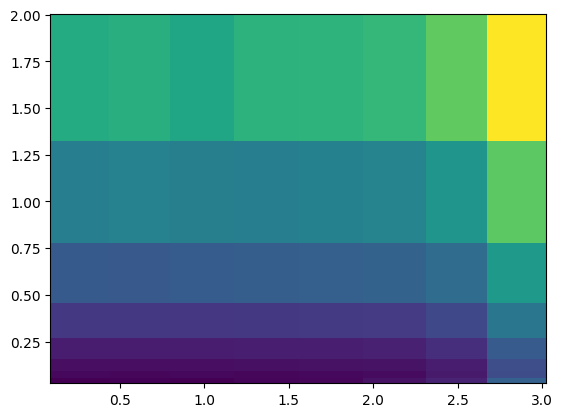

In [13]:
plt.pcolormesh(kperp, kpar, final_ps_2D[0])

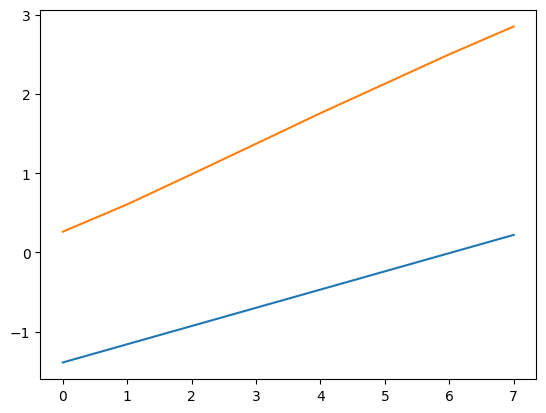

In [23]:
plt.plot(np.log10(kpar))
plt.plot(kperp)

In [10]:
print(bins_par)

[0.03773142 0.05442639 0.07850838 0.1132459  0.16335369 0.23563262
 0.33989272 0.49028469 0.70722041 1.02014346]


In [ ]:
lc = p21c.outputs.LightCone.read('/home/allomere/Documents/projects/master/data_emcee_1d/fiducial_cone.h5')
_,_ = p21c.plotting.lightcone_sliceplot(lc)
from powerbox import get_power

ps3 = calculate_ps(lc = lc.lightcones['brightness_temp'] , 
                           lc_redshifts=lc.lightcone_redshifts, 
                           box_length=lc.user_params.BOX_LEN, 
                           box_side_shape=lc.user_params.HII_DIM,
                           log_bins=False, zs = np.linspace(5.5, 25, 10), 
                           calc_1d=True, calc_2d=False,
                           nbins_1d=np.linspace(0.1,1,10), bin_ave=True, 
                           k_weights=ignore_zero_absk,postprocess=True, chunk_size=40,
                           get_vat)
print(ps3['k'].size)


In [ ]:
print(ps.shape)
plt.clf()
plt.plot(np.log10(ps3['k']), np.log10(ps).T, label=np.linspace(5.5, 25, 10, dtype=int))
plt.legend()
plt.show()
plt.plot(np.log10(k2).T, np.log10(ps2*k2**2).T,label=np.linspace(5.5, 25, 10, dtype=int))
plt.legend()
plt.show()
plt.plot(np.log10(ps3['k']), np.log10(ps3['ps_1D']).T,label=np.linspace(5.5, 25, 10, dtype=int)) 
plt.legend()
plt.show()

In [ ]:
ps.shape

In [ ]:
sensitivity = PowerSpectrum(
    observation=Observation(
        observatory=Observatory(
            antpos=hera(hex_num=7, separation=14 * un.m),
            beam=GaussianBeam(frequency=135.0 * un.MHz, dish_size=14 * un.m),
            latitude=38 * un.deg,
        )
    )
)

observatory = sensitivity.observation.observatory

plt.figure(figsize=(5, 4.5))
plt.scatter(observatory.baselines_metres[:, :, 0], observatory.baselines_metres[:, :, 1], alpha=0.1)
plt.xlabel("Baseline Length [x, m]")
plt.ylabel("Baseline Length [y, m]")
plt.show()

kperp = un.Quantity(np.linspace(0.01, 0.07, 15), "littleh/Mpc")
kpar = un.Quantity(np.linspace(0.1, 2, 15), "littleh/Mpc")
sense_gridded = sensitivity.calculate_sensitivity_2d_grid(kperp_edges=kperp, kpar_edges=kpar)
plt.imshow(np.log10(sense_gridded.value.T), origin="lower")
plt.colorbar()

In [ ]:
# initialize probability class

prior_ranges = {
    "astro_params": {
        "L_X": [38, 42],
        "NU_X_THRESH": [100, 1500],
        "ION_Tvir_MIN": [4, 5.3],
        "HII_EFF_FACTOR": [10, 250]
    }
}

fiducial_parameter = {
    "user_params": {
        "HII_DIM": 80,
        "BOX_LEN": 200,
        "N_THREADS": 1,
        "USE_INTERPOLATION_TABLES": True,
    },
    "flag_options": {
        "USE_TS_FLUCT": False,
        "INHOMO_RECO": False
    },
    "astro_params": {
        "INHOMO_RECO": False,
        "L_X": 40,
        "NU_X_THRESH": 500,
        "ION_Tvir_MIN": 5,
        "HII_EFF_FACTOR": 30
    },
    "make_statistics": False,
}

probability = Probability(prior_ranges=prior_ranges, z_eval=np.linspace(5.5,30, 15), bins=10, debug=True, 
                          fmodel_path="./emcee_data/fiducial_ps.npy", summary_statistics = '1dps')

emcee = Flower(Probability=probability, redshift=5, data_path="./emcee_data/", noise_type=[1,0,5],
                       regenerate_fiducial=True, fid_params=fiducial_parameter, debug=True)

emcee.make_fiducial()


emcee.run_emcee(threads=6, nsteps=240, walkers=24)


Set initial parameters...
initialize Simulation class...
Search for existing fiducial lightcone...
Begin lightcone simulation ...
Parameter successfully refreshed.
Current parameters are:
astro_params: AstroParams:
    ALPHA_ESC       : -0.5
    ALPHA_STAR      : 0.5
    ALPHA_STAR_MINI : 0.5
    A_LW            : 2.0
    A_VCB           : 1.0
    BETA_LW         : 0.6
    BETA_VCB        : 1.8
    F_ESC10         : 0.1
    F_ESC7_MINI     : 0.01
    F_H2_SHIELD     : 0.0
    F_STAR10        : 0.05011872336272722
    F_STAR7_MINI    : 0.01
    HII_EFF_FACTOR  : 30
    ION_Tvir_MIN    : 100000
    L_X             : 10000000000000000000000000000000000000000
    L_X_MINI        : 1e+40
    M_TURN          : 501187233.6272715
    NU_X_THRESH     : 500
    N_RSD_STEPS     : 20
    R_BUBBLE_MAX    : 15.0
    X_RAY_SPEC_INDEX: 1.0
    X_RAY_Tvir_MIN  : 100000
    t_STAR          : 0.5
    
cosmo_params: CosmoParams:
    OMb        : 0.04897468161869667
    OMm        : 0.30964144154550644
   

/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/py21cmfast/wrapper.py:2628: DeprecationWarning: passing redshift directly is deprecated, please use the Lightconer interface instead
  warnings.warn(


Done simulating.
Do sanity check...
Sanity check passed.
Returning lightcone now.
Gaussian noise will be added...
Save fiducial_cone to disk...
New lightcone successfully computed and saved.
Search for existing summary statistics...


/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)


PS is (array([[  9.58034261,   6.7330206 ,   7.81648673,  12.90562772,
         22.8706362 ,  38.74072632,  60.94962457,  90.99478322,
        129.58133756, 170.66159579],
       [ 28.38995184,  27.34784009,  27.91298606,  32.23237714,
         42.06423504,  61.12252412,  86.97458039, 123.08236316,
        166.85023088, 223.89380908],
       [  8.82212582,  24.1638504 ,  30.98982469,  36.89497423,
         45.59513525,  62.93814534,  86.59820563, 121.31162007,
        163.02148549, 209.20107515],
       [  7.9291667 ,  19.36881308,  27.67821158,  32.21802473,
         38.45240631,  53.08445534,  73.46906204, 103.23743348,
        144.36670582, 185.09219356],
       [ 11.26135606,  21.25626365,  25.99577083,  27.53683243,
         32.56150701,  44.82933575,  64.56509751,  92.468706  ,
        129.05766612, 171.20077626],
       [ 12.33891337,  22.4431273 ,  25.21992554,  25.19620925,
         29.07946671,  40.73868372,  59.4494464 ,  87.80349377,
        122.36229001, 165.30260288],
   

/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/py21cmfast/wrapper.py:2628: DeprecationWarning: passing redshift directly is deprecated, please use the Lightconer interface instead
  warnings.warn(
/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/py21cmfast/wrapper.py:2628: DeprecationWarning: passing redshift directly is deprecated, please use the Lightconer interface instead
  warnings.warn(
/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/py21cmfast/wrapper.py:2628: DeprecationWarning: passing redshift directly is deprecated, please use the Lightconer interface instead
  warnings.warn(
/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/py21cmfast/wrapper.py:2628: DeprecationWarning: passing redshift directly is deprecated, please use the Lightconer interface instead
  warnings.warn(
/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/py21cmfast

dict_keys(['brightness_temp', 'density', 'xH_box'])


/tmp/ipykernel_15592/15835897.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


"res = calculate_ps(lc = lc.lightcones['brightness_temp'] , lc_redshifts=lc.lightcone_redshifts, \n                           box_length=lc.user_params.BOX_LEN, box_side_shape=lc.user_params.HII_DIM,\n                           log_bins=False, zs = np.linspace(5.5,30, 15), calc_1d=True, calc_2d=True, get_variance=True,\n                           nbins=10, kpar_bins=10, bin_ave=True, k_weights=ignore_zero_absk, postprocess=True)\nprint(res.keys())"

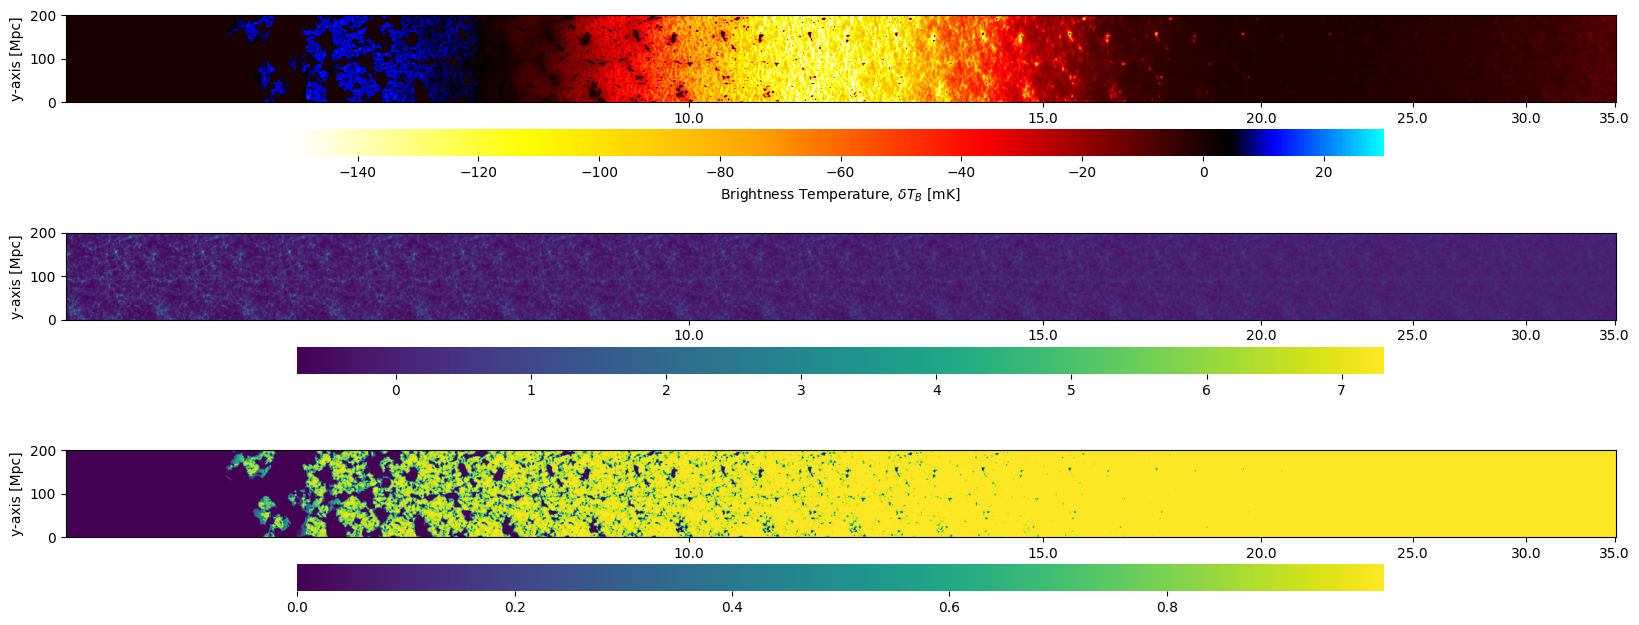

In [11]:

#lc = p21c.outputs.LightCone.read("/home/allomere/Documents/projects/master/data/lightcone_np/simrun_0.h5")
lcb = lc.brightness_temp
print(lc.lightcones.keys())

fig, ax = plt.subplots(3,1, figsize=(20,8))

for i, field in enumerate(list(lc.lightcones.keys())):

    fig, ax[i] = p21c.plotting.lightcone_sliceplot(lc, fig=fig, ax=ax[i], kind=field)

fig.savefig("lightcone.png")
fig.show()

"""res = calculate_ps(lc = lc.lightcones['brightness_temp'] , lc_redshifts=lc.lightcone_redshifts, 
                           box_length=lc.user_params.BOX_LEN, box_side_shape=lc.user_params.HII_DIM,
                           log_bins=False, zs = np.linspace(5.5,30, 15), calc_1d=True, calc_2d=True, get_variance=True,
                           nbins=10, kpar_bins=10, bin_ave=True, k_weights=ignore_zero_absk, postprocess=True)
print(res.keys())"""

In [17]:
print(res['full_var_2D'].shape)
print(res['final_var_2D'].shape)

(15, 10, 80)
(15, 10, 10)


(15, 15, 80)


In [ ]:
perp_bins, par_bins = 10,10

res = calculate_ps(lc = lc.lightcones['brightness_temp'] , lc_redshifts=lc.lightcone_redshifts, 
                           box_length=lc.user_params.BOX_LEN, box_side_shape=lc.user_params.HII_DIM,
                           log_bins=False, zs = np.linspace(5.5,30, 10), calc_1d=True, calc_2d=True, nbins=perp_bins, kpar_bins=par_bins,
                            bin_ave=True, k_weights=ignore_zero_absk, nbins_1d=15, get_variance=True, postprocess=False)
# plot 1d ps 

print(res.keys())

k = res['k']

plt.title("1D PS")
plt.xlabel(r'$\log_{10} k [h/$Mpc$]$')
plt.ylabel(r'$\log_{10} P(k)$ $[mK^2]$')
plt.plot(np.log10(k), np.log10(res['ps_1D']).T, label=np.round(np.linspace(5.5,30, 10),1))
plt.legend()
plt.tight_layout()
#plt.savefig("1d_ps.png", dpi=400)
plt.show()
plt.clf()

plt.title("Variance 1D PS")
plt.plot(np.log10(k), np.log10(res['var_1D']).T, label=np.round(np.linspace(5.5,30, 10),1))
plt.plot(np.log10(k), np.log10(res['ps_1D']**2/160**2).T, label=np.round(np.linspace(5.5,30, 10),1), ls = 'dotted')
plt.xlabel(r'$\log_{10} k [h/$Mpc$]$')
plt.ylabel(r'$\log_{10} \sigma^2(P(k))$ $[mK^2]$')
plt.legend()
plt.tight_layout()
plt.savefig("var_1d_ps_comp.png", dpi=400)
plt.show()
plt.clf()

for zi,z in enumerate(np.round(np.linspace(5.5,30, 10),1)):
    plt.scatter(np.log10(res['ps_1D'])[zi], np.log10(res['var_1D'])[zi], label=str(z), alpha=0.8)
plt.title("Power vs Variance 1D PS")
plt.xlabel(r'$\log_{10} P(k)$ $[mK^2]$')
plt.ylabel(r'$\log_{10} \sigma^2(P(k))$ $[mK^2]$')
plt.legend()
plt.tight_layout()
#plt.savefig("power_vs_variance_1d_ps.png", dpi=400)
plt.show()
plt.clf()

In [ ]:
perp_bins, par_bins = 10,10

res = calculate_ps(lc = lc.lightcones['brightness_temp'] , lc_redshifts=lc.lightcone_redshifts, 
                           box_length=lc.user_params.BOX_LEN, box_side_shape=lc.user_params.HII_DIM,
                           log_bins=False, zs = np.linspace(5.5,30, 10), calc_1d=True, calc_2d=True, nbins=15, kpar_bins=15,
                            bin_ave=True, k_weights=ignore_zero_absk, nbins_1d=15, get_variance=True, postprocess=False)
# plot 1d ps 

print(res.keys())

k = res['k']

plt.title("1D PS")
plt.ylabel(r'$\log_{10} P(k)$ $[mK^2]$')
plt.plot(np.log10(k), np.log10(res['ps_1D']).T, label=np.round(np.linspace(5.5,30, 10),1))
plt.legend()
plt.tight_layout()
plt.savefig("1d_ps.png", dpi=400)
plt.show()
plt.clf()

plt.title("Variance 1D PS")
plt.plot(np.log10(k), np.log10(res['var_1D']).T, label=np.round(np.linspace(5.5,30, 10),1))
plt.xlabel(r'$\log_{10} k [h/$Mpc$]$')
plt.ylabel(r'$\log_{10} \sigma^2(P(k))$ $[mK^2]$')
plt.legend()
plt.tight_layout()
plt.savefig("var_1d_ps.png", dpi=400)
plt.show()
plt.clf()

for zi,z in enumerate(np.round(np.linspace(5.5,30, 10),1)):
    plt.scatter(np.log10(res['ps_1D'])[zi], np.log10(res['var_1D'])[zi], label=str(z), alpha=0.8)
plt.title("Power vs Variance 1D PS")
plt.xlabel(r'$\log_{10} P(k)$ $[mK^2]$')
plt.ylabel(r'$\log_{10} \sigma^2(P(k))$ $[mK^2]$')
plt.legend()
plt.tight_layout()
plt.savefig("power_vs_variance_1d_ps.png", dpi=400)
plt.show()
plt.clf()

# plot 2d ps

k_par, k_perp = res['full_kpar'][0][21:], res['full_kperp']
ps2d, ps2d_var = res['full_ps_2D'][:,:,21:], res['full_var_2D'][:,:,21:]
print(ps2d.shape)
print(ps2d_var.shape)
print(k_par.shape)
print(k_perp.shape)

fig = plt.figure(figsize=(perp_bins, par_bins))
plt.title("2D PS")
gs = fig.add_gridspec(par_bins, perp_bins, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')
#fig.suptitle('Sharing x per column, y per row')
up_r, low_r = np.max(np.log10(ps2d)), np.min(np.log10(ps2d))
for i in range(par_bins):
    for j in range(perp_bins):
        ax[i,j].plot(np.round(np.linspace(5.5,30, 10),1), np.log10(ps2d[:,i,j]))
        ax[i,j].set_ylim(low_r, up_r)
        ax[i,j].set_xlabel(np.round(k_par[j],1))
        ax[i,j].set_ylabel(np.round(k_perp[i],1))
fig.supylabel(r'$\log_{10}k_\perp$' + '\n' + r'$\log_{10} P(k)$ $[mK^2]$')
fig.supxlabel(r'$z$' + '\n' + r'$\log_{10}k_\parallel$')
for ax in fig.get_axes():
    ax.label_outer()
fig.tight_layout()
fig.show()
fig.savefig("2d_ps.png", dpi=400)


fig = plt.figure(figsize=(perp_bins, par_bins))

plt.title("Variance 2D PS")
gs = fig.add_gridspec(par_bins, perp_bins, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')
#fig.suptitle('Sharing x per column, y per row')
up_r, low_r = np.max(np.log10(ps2d_var)), np.min(np.log10(ps2d_var))
for i in range(par_bins):
    for j in range(perp_bins):
        ax[i,j].plot(np.round(np.linspace(5.5,30, 10),1), np.log10(ps2d_var[:,i,j]))
        ax[i,j].set_ylim(low_r, up_r)
        ax[i,j].set_xlabel(np.round(np.log10(k_par[j]),1))
        ax[i,j].set_ylabel(np.round(np.log10(k_perp[i]),1))
fig.supylabel(r'$\log_{10} k_\perp$' + '\n' + r'$\log_{10} \sigma^2(P(k))$ $[mK^2]$')
fig.supxlabel(r'$z$' + '\n' + r'$\log_{10}k_\parallel$')
for ax in fig.get_axes():
    ax.label_outer()
fig.tight_layout()
fig.show()
fig.savefig("var_2d_ps.png", dpi=400)

fig = plt.figure(figsize=(perp_bins, par_bins))
plt.title("Power vs Variance 2D PS")
gs = fig.add_gridspec(par_bins, perp_bins, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')
#fig.suptitle('Sharing x per column, y per row')
#up_r, low_r = np.max(np.log10(res['full_var_2D'])), np.min(np.log10(res['full_var_2D']))
for i in range(par_bins):
    for j in range(perp_bins):
        ax[i,j].scatter(np.log10(ps2d[:,i,j]), np.log10(ps2d_var[:,i,j]), s=4)
        #ax[i,j].set_ylim(low_r, up_r)
        ax[i,j].set_xlabel(np.round(np.log10(k_par[j]),1))
        ax[i,j].set_ylabel(np.round(np.log10(k_perp[i]),1))
fig.supylabel(r'$\log_{10} k_\perp$' + '\n' + r'$\log_{10} \sigma^2(P(k))$ $[mK^2]$')
fig.supxlabel(r'$\log_{10} P(k)$ $[mK^2]$' + '\n' + r'$\log_{10}k_\parallel$')
for ax in fig.get_axes():
    ax.label_outer()
fig.tight_layout()
fig.show()
fig.savefig("power_vs_variance_2d_ps.png", dpi=400)

In [ ]:

res = calculate_ps(lc = np.random.rand(200,200,1600), lc_redshifts=np.linspace(5,30,1600), 
                           box_length=100, box_side_shape=200,
                           log_bins=False, zs = np.linspace(5.5,30, 10), calc_1d=True, calc_2d=True, nbins=15, kpar_bins=15,
                            bin_ave=True, k_weights=ignore_zero_absk, nbins_1d=15, get_variance=True, postprocess=False)
print(res['full_ps_2D'].shape)

In [ ]:
res = calculate_ps(lc = lc.lightcones['brightness_temp'] , lc_redshifts=lc.lightcone_redshifts, 
                           box_length=lc.user_params.BOX_LEN, box_side_shape=lc.user_params.HII_DIM,
                           log_bins=False, zs = np.linspace(5.5,30, 10), calc_1d=True, calc_2d=True, nbins=15, kpar_bins=15,
                            bin_ave=True, k_weights=ignore_zero_absk, nbins_1d=15, get_variance=True, postprocess=False)

print(res['full_kpar'][0])
print(res['full_kperp'])
ps2d = res['full_ps_2D']

for i in range(10):
    plt.imshow(np.log10(ps2d[i]), origin='lower')
    plt.show()

In [ ]:
from py21cmfast.outputs import LightCone
from py21cmfast.plotting import lightcone_sliceplot
lc = LightCone.read("/home/potato/Documents/projects/master/data/data_smol/simrun_243.h5")
print(lc.user_params.BOX_LEN)

In [25]:
import torch

In [ ]:
torch.load("/home/potato/Documents/projects/master/data/datax5/batch_1.pt")['images'].shape

In [ ]:
p21c.outputs.LightCone.save(lc, 'test.h5', clobber=True)

In [ ]:
{'global_params': {'M_WDM': 3.501515617898722}, 
 'cosmo_params': {'OMm': 0.14078494774504743}, 
 'astro_params': {'L_X': 2.093953125940754, 
                  'NU_X_THRESH': 453.94456146918685, 
                  'ION_Tvir_MIN': 0.25907883271173016, 
                  'HII_EFF_FACTOR': 192.22061520453673}}

In [ ]:
from powerbox import get_power
import numpy as np
data = np.random.rand(100,100,100)
from matplotlib import pyplot as plt

get_power?
#ps, k, var = get_power(data, boxlength=100, bin_ave=True, get_variance=True, 
#                       ignore_zero_mode=True)

In [ ]:
#field = lightcone.brightness_temp[:,:,zbins[bin]:zbins[bin+1]]
import py21cmfast as p21c
from py21cmfast_tools import calculate_ps
lightcone = p21c.outputs.LightCone.read("../data/res_comp/110_res_False_.h5")
field = lightcone.brightness_temp[:,:, 1100:1400]
boxlength = lightcone.cell_size*np.asarray(lightcone.brightness_temp[:,:1100:1400].shape)

ps_2d, kperp, var, kpar, sumweights = get_power(field, boxlength=boxlength, res_ndim=2, bins = 15, 
                        ignore_zero_mode=True, bin_ave=True, get_variance=True, return_sumweights=True) 

print(ps_2d.shape)
print(kperp.shape)
print(kpar.shape)
print(var.shape)
print(sumweights[0].shape)

In [ ]:
#field = lightcone.brightness_temp[:,:,zbins[bin]:zbins[bin+1]]
import py21cmfast as p21c
lightcone = p21c.outputs.LightCone.read("../data/res_comp/110_res_False_.h5")
field = lightcone.brightness_temp[:,:, 1100:1400]
boxlength = lightcone.cell_size*np.asarray(lightcone.brightness_temp[:,:500:800].shape)

res = calculate_ps(lc = field, lc_redshifts=lightcone.lightcone_redshifts, box_length=200, box_side_shape=110, nbins = 20, log_bins=False)

In [ ]:
res.keys()
print(res['full_ps_2D'].shape)
print(res['final_ps_2D'].shape)

In [1]:
import numpy as np
from powerbox.tools import (
    _magnitude_grid,
    above_mu_min_angular_generator,
    get_power,
    ignore_zero_ki,
    power2delta,
    regular_angular_generator,
)


def calculate_ps(  # noqa: C901
    lc,
    lc_redshifts,
    box_length,
    box_side_shape=None,
    zs=None,
    chunk_size=None,
    chunk_skip=37,
    calc_2d=True,
    nbins=50,
    k_weights=ignore_zero_ki,
    postprocess=True,
    kpar_bins=None,
    log_bins=True,
    crop=None,
    calc_1d=False,
    nbins_1d=14,
    calc_global=False,
    mu=None,
    bin_ave=True,
    interp=None,
    prefactor_fnc=power2delta,
    interp_points_generator=None,
):
    r"""Calculate power spectra from a lightcone.

    Parameters
    ----------
    lc : np.ndarray
        The lightcone whose power spectrum we want to calculate.
        The lightcone should be a 3D array with shape
        [box_side_shape, box_side_shape, len(lc_redshifts)].
    lc_redshifts : np.ndarray
        The redshifts of the lightcone.
    box_length : float
        The side length of the box in cMpc.
    box_side_shape : int, optional
        The number of pixels in one side of the box
        (HII_DIM parameter in 21cmFAST).
    zs : np.ndarray, optional
        The redshifts at which to calculate the power spectrum.
        If None, the lightcone is broken up into chunks using arguments
        chunk_skip and chunk_size.
    chunk_size : int, optional
        The size of the chunks to break the lightcone into.
        If None, the chunk is assumed to be a cube i.e. chunk_size = box_side_shape.
    chunk_skip : int, optional
        The number of lightcone slices to skip between chunks. Default is 37.
    calc_2d : bool, optional
        If True, calculate the 2D power spectrum.
    nbins : int, optional
        The number of bins to use for the kperp axis of the 2D PS.
    k_weights : callable, optional
        A function that takes a frequency tuple and returns
        a boolean mask for the k values to ignore.
        See powerbox.tools.ignore_zero_ki for an example
        and powerbox.tools.get_power documentation for more details.
        Default is powerbox.tools.ignore_zero_ki, which excludes
        the power any k_i = 0 mode.
        Typically, only the central zero mode |k| = 0 is excluded,
        in which case use powerbox.tools.ignore_zero_absk.
    postprocess : bool, optional
        If True, postprocess the 2D PS.
        This step involves cropping out empty bins and/or log binning the kpar axis.
    kpar_bins : int or np.ndarray, optional
        Affects only the postprocessing step.
        The number of bins or the bin edges to use for binning the kpar axis.
        If None, produces 16 bins.
    log_bins : bool, optional
        Affects only the postprocessing step. If True, log bin the kpar axis.
    crop : list, optional
        Affects only the postprocessing step.
        The crop range for the (log-binned) PS. If None, crops out only the empty bins.
    calc_1d : bool, optional
        If True, calculate the 1D power spectrum.
    nbins_1d : int, optional
        The number of bins on which to calculate 1D PS.
    calc_global : bool, optional
        If True, calculate the global brightness temperature.
    mu : float, optional
        The minimum value of
        :math:`\\cos(\theta), \theta = \arctan (k_\\perp/k_\\parallel)`
        for all calculated PS.
        If None, all modes are included.
    bin_ave : bool, optional
        If True, return the center value of each kperp and kpar bin
        i.e. len(kperp) = ps_2d.shape[0].
        If False, return the left edge of each bin
        i.e. len(kperp) = ps_2d.shape[0] + 1.
    interp : str, optional
        If True, use linear interpolation to calculate the PS
        at the points specified by interp_points_generator.
        Note that this significantly slows down the calculation.
    prefactor_fnc : callable, optional
        A function that takes a frequency tuple and returns the prefactor
        to multiply the PS with.
        Default is powerbox.tools.power2delta, which converts the power
        P [mK^2 Mpc^{-3}] to the dimensionless power :math:`\\delta^2` [mK^2].
    interp_points_generator : callable, optional
        A function that generates the points at which to interpolate the PS.
        See powerbox.tools.get_power documentation for more details.
    """
    # Split the lightcone into chunks for each redshift bin
    # Infer HII_DIM from lc side shape
    if box_side_shape is None:
        box_side_shape = lc.shape[0]
    if zs is None:
        if chunk_size is None:
            chunk_size = box_side_shape
        n_slices = lc.shape[-1]
        chunk_indices = list(range(0, n_slices - chunk_size, chunk_skip))
    else:
        if chunk_size is None:
            chunk_size = box_side_shape
        chunk_indices = np.array(
            np.max(
                [
                    np.zeros_like(zs),
                    np.array([np.argmin(abs(lc_redshifts - z)) for z in zs])
                    - chunk_size // 2,
                ],
                axis=0,
            ),
            dtype=np.int32,
        )
    zs = []  # all redshifts that will be computed
    lc_ps_2d = []
    clean_lc_ps_2d = []
    if calc_global:
        tb = []
    if calc_1d:
        lc_ps_1d = []
    out = {}

    if interp:
        interp = "linear"

    for i in chunk_indices:
        start = i
        end = i + chunk_size
        if end > len(lc_redshifts):
            shift_it_back_by_a_few_bins = end - len(lc_redshifts)
            start -= shift_it_back_by_a_few_bins
            end = len(lc_redshifts)
        chunk = lc[..., start:end]
        zs.append(lc_redshifts[(start + end) // 2])
        if calc_global:
            tb.append(np.mean(chunk))
        if calc_2d:
            ps_2d, kperp, nmodes, kpar = get_power(
                chunk,
                (box_length, box_length, box_length * chunk.shape[-1] / box_side_shape),
                res_ndim=2,
                bin_ave=bin_ave,
                bins=nbins,
                log_bins=log_bins,
                nthreads=1,
                k_weights=k_weights,
                prefactor_fnc=prefactor_fnc,
                interpolation_method=interp,
                return_sumweights=True,
            )
            if postprocess:
                clean_ps_2d, clean_kperp, clean_kpar, clean_nmodes = postprocess_ps(
                    ps_2d,
                    kperp,
                    kpar,
                    log_bins=log_bins,
                    kpar_bins=kpar_bins,
                    crop=crop.copy() if crop is not None else crop,
                    kperp_modes=nmodes,
                    return_modes=True,
                )
                clean_lc_ps_2d.append(clean_ps_2d)

            lc_ps_2d.append(ps_2d)

        if calc_1d:
            if mu is not None:
                if interp is None:

                    def mask_fnc(freq, absk):
                        kz_mesh = np.zeros((len(freq[0]), len(freq[1]), len(freq[2])))
                        kz = freq[2]
                        for i in range(len(kz)):
                            kz_mesh[:, :, i] = kz[i]
                        phi = np.arccos(kz_mesh / absk)
                        mu_mesh = abs(np.cos(phi))
                        kmag = _magnitude_grid([c for i, c in enumerate(freq) if i < 2])
                        return np.logical_and(mu_mesh > mu, ignore_zero_ki(freq, kmag))

                    k_weights1d = mask_fnc

                if interp is not None:
                    k_weights1d = ignore_zero_ki

                    interp_points_generator = above_mu_min_angular_generator(mu=mu)
            else:
                k_weights1d = ignore_zero_ki
                if interp is not None:
                    interp_points_generator = regular_angular_generator()
            ps_1d, k, nmodes_1d = get_power(
                chunk,
                (box_length, box_length, box_length * chunk.shape[-1] / box_side_shape),
                bin_ave=bin_ave,
                bins=nbins_1d,
                log_bins=log_bins,
                k_weights=k_weights1d,
                prefactor_fnc=prefactor_fnc,
                interpolation_method=interp,
                interp_points_generator=interp_points_generator,
                return_sumweights=True,
            )
            lc_ps_1d.append(ps_1d)

    if calc_1d:
        out["k"] = k
        out["ps_1D"] = np.array(lc_ps_1d)
        out["Nmodes_1D"] = nmodes_1d
        out["mu"] = mu
    if calc_2d:
        out["full_kperp"] = kperp
        out["full_kpar"] = kpar
        out["full_ps_2D"] = np.array(lc_ps_2d)
        out["final_ps_2D"] = np.array(clean_lc_ps_2d)
        out["final_kpar"] = clean_kpar
        out["final_kperp"] = clean_kperp
        out["full_Nmodes"] = nmodes
        out["final_Nmodes"] = clean_nmodes
    if calc_global:
        out["global_Tb"] = np.array(tb)
    out["redshifts"] = np.array(zs)

    return out


def log_bin(ps, kperp, kpar, bins=None):
    r"""
    Log bin a 2D PS along the kpar axis and crop out empty bins in both axes.

    Parameters
    ----------
    ps : np.ndarray
        The 2D power spectrum of shape [len(kperp), len(kpar)].
    kperp : np.ndarray
        Values of kperp.
    kpar : np.ndarray
        Values of kpar.
    bins : np.ndarray or int, optional
        The number of bins or the bin edges to use for binning the kpar axis.
        If None, produces 16 bins logarithmically spaced between
        the minimum and maximum `kpar` supplied.

    """
    if bins is None:
        bins = np.logspace(np.log10(kpar[0]), np.log10(kpar[-1]), 17)
    elif isinstance(bins, int):
        bins = np.logspace(np.log10(kpar[0]), np.log10(kpar[-1]), bins + 1)
    elif isinstance(bins, (np.ndarray, list)):
        bins = np.array(bins)
    else:
        raise ValueError("Bins should be np.ndarray or int")
    modes = np.zeros(len(bins) - 1)
    new_ps = np.zeros((len(kperp), len(bins) - 1))
    for i in range(len(bins) - 1):
        m = np.logical_and(kpar > bins[i], kpar < bins[i + 1])
        new_ps[:, i] = np.nanmean(ps[:, m], axis=1)
        modes[i] = np.sum(m)
    bin_centers = np.exp((np.log(bins[1:]) + np.log(bins[:-1])) / 2)
    return new_ps, kperp, bin_centers, modes


def postprocess_ps(
    ps,
    kperp,
    kpar,
    kpar_bins=None,
    log_bins=True,
    crop=None,
    kperp_modes=None,
    return_modes=False,
):
    """
    Postprocess a 2D PS by cropping out empty bins and log binning the kpar axis.

    Parameters
    ----------
    ps : np.ndarray
        The 2D power spectrum of shape [len(kperp), len(kpar)].
    kperp : np.ndarray
        Values of kperp.
    kpar : np.ndarray
        Values of kpar.
    kpar_bins : np.ndarray or int, optional
        The number of bins or the bin edges to use for binning the kpar axis.
        If None, produces 16 bins log spaced between the min and max `kpar` supplied.
    log_bins : bool, optional
        If True, log bin the kpar axis.
    crop : list, optional
        The crop range for the log-binned PS. If None, crops out all empty bins.
    kperp_modes : np.ndarray, optional
        The number of modes in each kperp bin.
    return_modes : bool, optional
        If True, return a grid with the number of modes in each bin.
        Requires kperp_modes to be supplied.
    """
    kpar = kpar[0]
    m = kpar > 1e-10
    if ps.shape[0] < len(kperp):
        if log_bins:
            kperp = np.exp((np.log(kperp[1:]) + np.log(kperp[:-1])) / 2.0)
        else:
            kperp = (kperp[1:] + kperp[:-1]) / 2
    kpar = kpar[m]
    ps = ps[:, m]
    mkperp = ~np.isnan(kperp)
    if kperp_modes is not None:
        kperp_modes = kperp_modes[mkperp]
    kperp = kperp[mkperp]
    ps = ps[mkperp, :]

    # Bin kpar in log
    rebinned_ps, kperp, log_kpar, kpar_weights = log_bin(
        ps, kperp, kpar, bins=kpar_bins
    )
    if crop is None:
        crop = [0, rebinned_ps.shape[0] + 1, 0, rebinned_ps.shape[1] + 1]
    # Find last bin that is NaN and cut out all bins before
    try:
        lastnan_perp = np.where(np.isnan(np.nanmean(rebinned_ps, axis=1)))[0][-1] + 1
        crop[0] = crop[0] + lastnan_perp
    except IndexError:
        pass
    try:
        lastnan_par = np.where(np.isnan(np.nanmean(rebinned_ps, axis=0)))[0][-1] + 1
        crop[2] = crop[2] + lastnan_par
    except IndexError:
        pass
    if kperp_modes is not None:
        final_kperp_modes = kperp_modes[crop[0] : crop[1]]
        kpar_grid, kperp_grid = np.meshgrid(
            kpar_weights[crop[2] : crop[3]], final_kperp_modes
        )

        nmodes = np.sqrt(kperp_grid**2 + kpar_grid**2)
        if return_modes:
            return (
                rebinned_ps[crop[0] : crop[1]][:, crop[2] : crop[3]],
                kperp[crop[0] : crop[1]],
                log_kpar[crop[2] : crop[3]],
                nmodes,
            )
    else:
        return (
            rebinned_ps[crop[0] : crop[1]][:, crop[2] : crop[3]],
            kperp[crop[0] : crop[1]],
            log_kpar[crop[2] : crop[3]],
        )

In [ ]:
plt.imshow(ps)

In [ ]:
print(np.mean(ps_par, axis=(1,2))*k_par)
print(np.mean(ps_perp, axis=(1))*k_perp)

In [ ]:
print(field[:,:,0].min())
plt.imshow(field[0,:,:])

In [ ]:
plt.imshow(np.log10(ps), origin='lower')
plt.colorbar()  
plt.show()
plt.imshow(np.log10(ps_var), origin='lower')
plt.colorbar()
plt.show()
plt.imshow(np.log10(ps/ps_var), origin='lower')
plt.colorbar()
plt.show()

In [ ]:
field.shape

In [65]:
ps_var = np.outer(var_perp_*k_perp**2, var_par_*k_par).T

In [ ]:
plt.imshow(ps, origin='lower')
plt.colorbar()  
plt.show()
plt.imshow(ps_var, origin='lower')
plt.colorbar()
plt.show()